![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Flux Processing Chain
</b>
</span>

---
**Notebook version**: `5` (5 Feb 2024)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# Background

- This notebook demonstrates part of the flux post-processing used for fluxes from Swiss FluxNet research stations
- For a description of the different flux levels, see [Flux Processing Chain](https://www.swissfluxnet.ethz.ch/index.php/data/ecosystem-fluxes/flux-processing-chain/)
- Flux calculations (Level-1) were done in a previous step
- This notebook uses the calculated fluxes (Level-1) and applies several post-processing steps:
    - Quality flag extension (Level-2)
    - Storage correction (Level-3.1)
    - Outlier removal (Level-3.2)
- Other flux levels are currently not produced in this example:
    - Gap-filling (Level-4.1)
    - NEE Partitioning (Level-4.2)

</br>

# User settings
`FLUXVAR` is the name of the flux variable in the data files. In the EddyPro `_fluxnet_` or - alternatively - `_full_output_` output files, the flux variables we primarily use are:
  - `FC`, `co2_flux` ... CO2 flux, becomes `NEE` after storage correction (Level-3.1)
  - `LE` ... Latent heat flux (water)
  - `H` ... Sensible heat flux
  - `FN2O`, `n2o_flux` ... Nitrous oxide flux
  - `FCH4`, `ch4_flux` ... Methane flux
  
There are more flux variables in the output file, but we rarely need them:
  - `FH2O`, `h2o_flux` ... H2O flux, very important but it is the same as `ET` and `LE` but with different units
  - `ET` ... Evapotranspiration, very important but it is the same as `FH2O` and `LE` but with different units. We can easily calculte `ET` later from `LE`, e.g. in `ReddyProc`.
  - `TAU` ... Momentum flux, a measure of the turbulent transfer of momentum between the land surface and the atmosphere

In [1]:
# FLUXVAR = "co2_flux"  # Name of the flux variable
FLUXVAR = "FC"  # Name of the flux variable in fluxnet output files: FC, FH2O, LE, ET, H, FN2O, FCH4
SOURCEDIRS = [r'L:\Sync\luhk_work\TMP\FRU']  # Folders where the EddyPro output files are located
SITE_LAT = 47.115833  # Latitude of site
SITE_LON = 8.537778  # Longitude of site
FILETYPE = 'EDDYPRO-FLUXNET-CSV-30MIN'  # Filetype of EddyPro output files, can be 'EDDYPRO-FLUXNET-CSV-30MIN' or 'EDDYPRO-FULL-OUTPUT-CSV-30MIN'
UTC_OFFSET = 1  # Time stamp offset in relation to UTC, e.g. 1 for UTC+01:00 (CET), important for the calculation of potential radiation for detecting daytime and nighttime
NIGHTTIME_THRESHOLD = 50  # Threshold for potential radiation in W m-2, conditions below threshold are nighttime
DAYTIME_ACCEPT_QCF_BELOW = 2
NIGHTTIMETIME_ACCEPT_QCF_BELOW = 2

</br>

# Imports
- This notebook uses `diive` ([source code](https://gitlab.ethz.ch/diive/diive)) to check eddy covariance fluxes for quality

In [2]:
import os
import importlib.metadata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
from diive.core.io.filereader import MultiDataFileReader, search_files
from diive.core.io.files import save_parquet, load_parquet
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.core.dfun.stats import sstats  # Time series stats
from diive.pkgs.fluxprocessingchain.fluxprocessingchain import FluxProcessingChain, LoadEddyProOutputFiles
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.74.0


</br>

# Docstring for `FluxProcessingChain`

In [3]:
help(FluxProcessingChain)

Help on class FluxProcessingChain in module diive.pkgs.fluxprocessingchain.fluxprocessingchain:

class FluxProcessingChain(builtins.object)
 |  FluxProcessingChain(maindf: pandas.core.frame.DataFrame, filetype: Literal['EDDYPRO-FLUXNET-CSV-30MIN', 'EDDYPRO-FULL-OUTPUT-CSV-30MIN'], fluxcol: str, site_lat: float, site_lon: float, utc_offset: int, metadata: pandas.core.frame.DataFrame = None, nighttime_threshold: float = 50)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, maindf: pandas.core.frame.DataFrame, filetype: Literal['EDDYPRO-FLUXNET-CSV-30MIN', 'EDDYPRO-FULL-OUTPUT-CSV-30MIN'], fluxcol: str, site_lat: float, site_lon: float, utc_offset: int, metadata: pandas.core.frame.DataFrame = None, nighttime_threshold: float = 50)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  finalize_level2(self, nighttime_threshold: int = 50, daytime_accept_qcf_below: int = 2, nighttimetime_accept_qcf_below: int = 2)
 |      Calculate overall quality flag QCF after

</br>

</br>

# Load data (2 options)

## Option 1: Load data from single or multiple output files
- Used to read data from the EddyPro _fluxnet_ output files

In [4]:
ep = LoadEddyProOutputFiles(sourcedir=SOURCEDIRS, filetype=FILETYPE)

In [5]:
ep.searchfiles()

Found 3 files with extension *.csv and file IDs ['eddypro_', '_fluxnet_']:
 Found file #1: L:\Sync\luhk_work\TMP\FRU\2020_eddypro_CH-FRU_FR-20230425-205325_fluxnet_2023-04-26T220030_adv.csv
 Found file #2: L:\Sync\luhk_work\TMP\FRU\2021_eddypro_CH-FRU_FR-20230425-205131_fluxnet_2023-04-26T214014_adv.csv
 Found file #3: L:\Sync\luhk_work\TMP\FRU\2022_eddypro_CH-FRU_FR-20230425-205042_fluxnet_2023-04-26T222351_adv.csv


In [6]:
ep.loadfiles()

Reading file 2020_eddypro_CH-FRU_FR-20230425-205325_fluxnet_2023-04-26T220030_adv.csv ...
Reading file 2021_eddypro_CH-FRU_FR-20230425-205131_fluxnet_2023-04-26T214014_adv.csv ...
Reading file 2022_eddypro_CH-FRU_FR-20230425-205042_fluxnet_2023-04-26T222351_adv.csv ...


In [7]:
maindf = ep.maindf
metadata = ep.metadata

</br>

## Option 2: Load data from `parquet` file
- Used to continue a previous session where another flux variable was already post-processed
- For example, if you have already post-processed CO2 flux and now want to post-process H2O flux
- Also detects time resolution of time series, this info was lost when saving to the parquet file

In [8]:
# maindf = load_parquet(filepath='mylovelyhorse.parquet')

</br>

## Check data

In [9]:
maindf.head()

AIR_MV  AIR_DENSITY  AIR_RHO_CP   AIR_CP  AOA_METHOD  AXES_ROTATION_METHOD  ...  W_ITC  W_ITC_TEST  WBOOST_APPLIED  WPL_APPLIED        ZL  ZL_UNCORR
TIMESTAMP_MIDDLE                                                                                   ...                                                                     
2019-12-31 19:15:00  0.024907      1.16085     1169.83  1007.74         0.0                   1.0  ...    6.0         1.0             0.0          1.0  3.079130   3.006370
2019-12-31 19:45:00  0.024865      1.16271     1171.77  1007.79         0.0                   1.0  ...   47.0         3.0             0.0          1.0 -0.096300  -0.099549
2019-12-31 20:15:00  0.024910      1.16061     1169.68  1007.81         0.0                   1.0  ...   27.0         2.0             0.0          1.0 -0.780695  -0.771121
2019-12-31 20:45:00  0.024886      1.16183     1170.78  1007.70         0.0                   1.0  ...   21.0         2.0             0.0          1.0  0.540130   0.545173
2019-12-31 21:15:00  0.024874      1.16239     1171.37  1007.73         0.0                   1.0  ...    9.0         1.0             0.0          1.0 -0.135396  -0.095764

[5 rows x 485 columns]

In [10]:
sstats(maindf[FLUXVAR])

FC
STARTDATE       2019-12-31 19:15
ENDDATE         2023-01-01 00:45
PERIOD        1096 days 05:30:00
NOV                        46335
MISSING                     6285
MISSING_PERC           11.944128
MEAN                   -2.353434
SD                      22.71197
VAR                   515.833587
SD/MEAN                -9.650568
SUM               -109046.343054
MEDIAN                 -0.789395
MIN                     -721.808
MAX                       595.24
P01                   -62.848228
P05                    -22.65998
P25                     -7.16415
P75                      2.46893
P95                     13.71979
P99                    59.912588

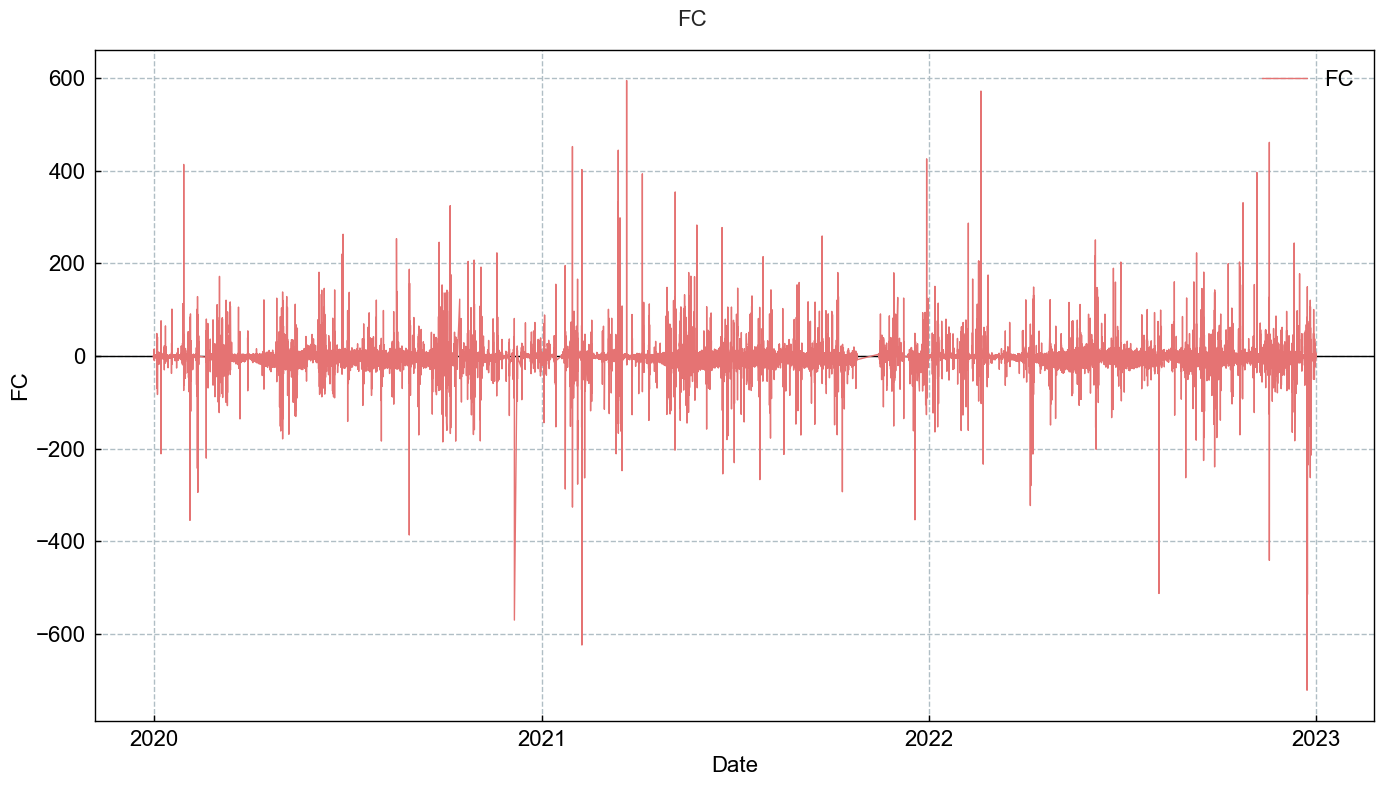

In [11]:
# TimeSeries(series=maindf[FLUXVAR]).plot_interactive()
TimeSeries(series=maindf[FLUXVAR]).plot()

</br>

</br>

# Initialize flux processing chain

- First we need to initialize the processing chain by providing some basic info.
- At the same time, some fundamental variables are also created: potential radiation, and two flags based on it: daytime flag (1=daytime) and nighttime flag (1=nighttime).

In [12]:
fpc = FluxProcessingChain(
    maindf=maindf,    
    filetype=FILETYPE,    
    fluxcol=FLUXVAR,    
    site_lat=SITE_LAT,
    site_lon=SITE_LON,
    utc_offset=UTC_OFFSET,
    metadata=metadata
)

Detected base variable CO2 for FC.
Calculated potential radiation from latitude and longitude (SW_IN_POT) ... 
Calculated daytime flag DAYTIME and nighttime flag NIGHTTIME from SW_IN_POT ...


- Let's check the flux processing chain dataframe: this are the data the chain is working with in this run:

In [13]:
fpc.fpc_df

FC  SW_IN_POT  DAYTIME  NIGHTTIME
TIMESTAMP_MIDDLE                                            
2019-12-31 19:15:00  0.738373        0.0      0.0        1.0
2019-12-31 19:45:00 -3.135800        0.0      0.0        1.0
2019-12-31 20:15:00 -2.667060        0.0      0.0        1.0
2019-12-31 20:45:00  1.086530        0.0      0.0        1.0
2019-12-31 21:15:00 -2.341840        0.0      0.0        1.0
...                       ...        ...      ...        ...
2022-12-31 22:45:00  1.210100        0.0      0.0        1.0
2022-12-31 23:15:00 -1.503480        0.0      0.0        1.0
2022-12-31 23:45:00  4.104030        0.0      0.0        1.0
2023-01-01 00:15:00  1.535880        0.0      0.0        1.0
2023-01-01 00:45:00  4.004600        0.0      0.0        1.0

[52620 rows x 4 columns]

</br>

</br>

---

# QUALITY FLAG EXTENSION (Level-2)

> Extract additional quality information from the EddyPro output and store it in newly added quality flags.



Note that the USTAR filtering is not part of the Level-2 calculations.

</br>

## User settings
- A test for missing values is always included: flag calculated here from missing flux values in the EddyPro output file

</br>

### SSITC tests (default: `True`)
- Flag calculated in EddyPro
- Combination of the two partial tests *steady state test* and *developed turbulent conditions test*
- This notebook expects the SSITC flag to follow the flagging policy according to Mauder and Foken 2004: 0 for best quality fluxes, 1 for fluxes suitable for general analysis such as annual budgets (although this is debatable) and 2 for fluxes that should be discarded from the dataset

In [14]:
TEST_SSITC = True  # Default True

</br>

### Gas completeness test (default: `True`)
- Flag calculated here from the gas number of records percentage in EddyPro output file
- Checks gas number of records available for each averaging Interval

In [15]:
TEST_GAS_COMPLETENESS = True  # Default True

</br>

### Spectral correction factor test (default: `True`)
- Flag calculated here from the gas `scf` variable in EddyPro output file

In [16]:
TEST_SPECTRAL_CORRECTION_FACTOR = True  # Default True

</br>

### Signal strength test

<div class="alert alert-block alert-info">
<b>Always recommended if flux was calculated using a gas analyzer.</b>
</div>  

<div class="alert alert-block alert-danger">
<b>Do not use for H (sensible heat flux).</b> This test is only relevant for fluxes where the concentration was measured by a gas analyzer, e.g. FC, FH2O, LE, ET, N2O, CH4, etc ... 
</div>  

- Signal strength / AGC / window dirtiness test (if available)
- Flag calculated here from the signal strength / AGC variable for the gas analyzer in EddyPro output file
- `SIGNAL_STRENGTH_COL`: Name of the column storing the signal strength, typically 'CUSTOM_AGC_MEAN' for LI-7500, 'CUSTOM_SIGNAL_STRENGTH_IRGA72_MEAN' for LI-7200, or something similar
- `SIGNAL_STRENGTH_THRESHOLD`: Signal strength threshold, flux values where threshold is exceeded are flagged as rejected
- `SIGNAL_STRENGTH_METHOD`: `discard above` flags fluxes where signal strength > threshold, `discard below` where signal strength < threshold

In [17]:
# Signal strength
TEST_SIGNAL_STRENGTH_COL = 'CUSTOM_AGC_MEAN'  # Typical variable name in fluxnet files
# TEST_SIGNAL_STRENGTH_COL = 'agc_mean'  # Typical variable name in full_output files
TEST_SIGNAL_STRENGTH_METHOD = 'discard above'
TEST_SIGNAL_STRENGTH_THRESHOLD = 90

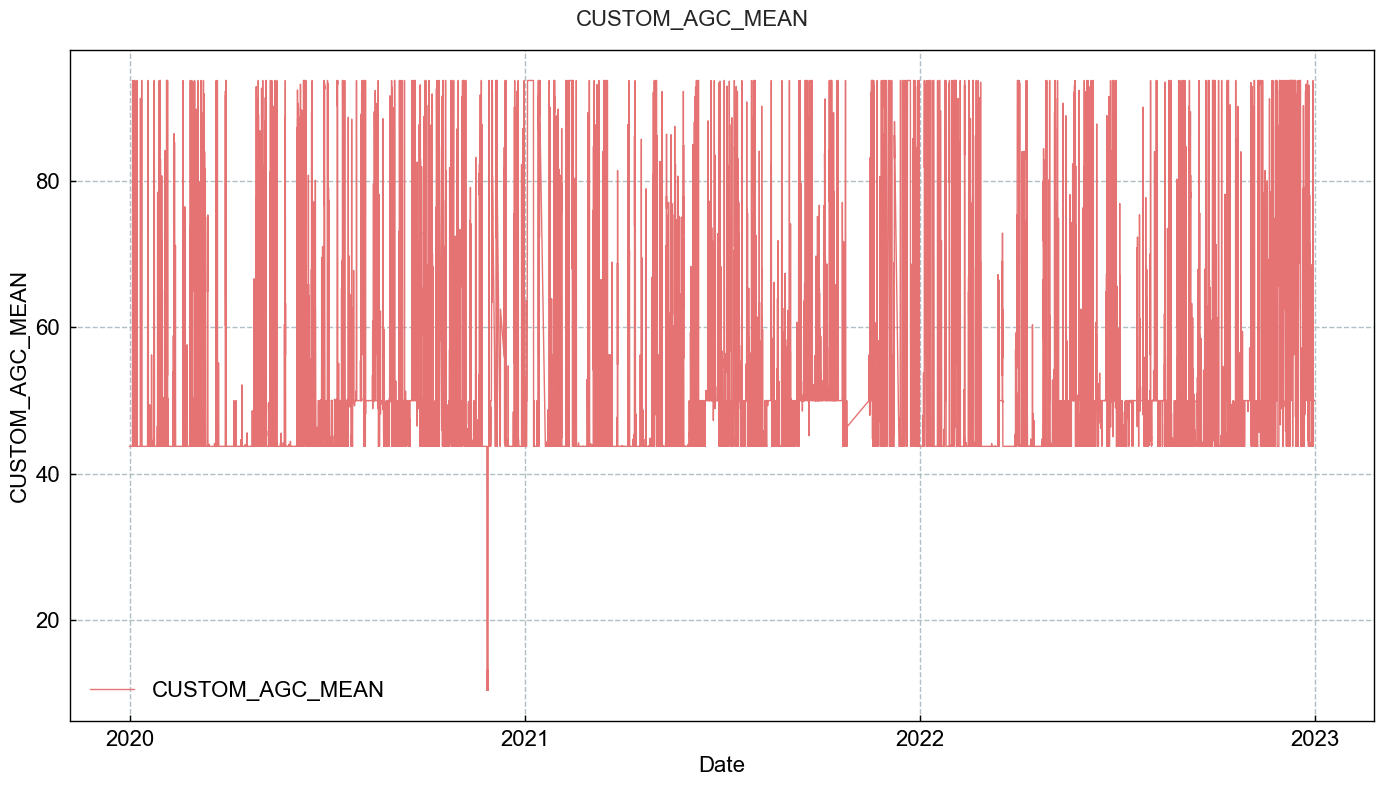

In [18]:
# TimeSeries(series=df_orig[SIGNAL_STRENGTH_COL]).plot_interactive()
TimeSeries(series=maindf[TEST_SIGNAL_STRENGTH_COL]).plot()

</br>

### Raw data screening tests
- Flags were calculated in EddyPro

In [19]:
TEST_RAWDATA_SPIKES = True  # Default True
TEST_RAWDATA_AMPLITUDE = True  # Default True
TEST_RAWDATA_DROPOUT = True  # Default True
TEST_RAWDATA_ABSLIM = False  # Default False
TEST_RAWDATA_SKEWKURT_HF = False  # Default False
TEST_RAWDATA_SKEWKURT_SF = False  # Default False
TEST_RAWDATA_DISCONT_HF = False  # Default False
TEST_RAWDATA_DISCONT_SF = False  # Default False

</br>

### Angle-of-attack test (default: `False`)
> This test calculates sample-wise Angle of Attacks throughout the current flux averaging period, and flags it if the percentage of angles of attack exceeding a user-defined range is beyond a (user-defined) threshold.  
> Source: [EddyPro help](https://www.licor.com/env/support/EddyPro/topics/despiking-raw-statistical-screening.html?Highlight=angle%20of%20attack#Angleofattack)  *(3 Jan 2024)*
- Flag was calculated in EddyPro

In [20]:
TEST_RAWDATA_ANGLE_OF_ATTACK = False  # Default False

</br>

### Steadiness of horizontal wind test (default: `False`)
> This test assesses whether the along-wind and crosswind components of the wind vector undergo a systematic reduction (or increase) throughout the file. If the quadratic combination of such systematic variations is beyond the user-selected limit, the flux averaging period is hard-flagged for instationary horizontal wind (Vickers and Mahrt, 1997, Par. 6g).  
> Source: [EddyPro help](https://www.licor.com/env/support/EddyPro/topics/despiking-raw-statistical-screening.html?Highlight=angle%20of%20attack#Steadinessofhorizontalwind)  *(3 Jan 2024)*
- Flag was calculated in EddyPro

In [21]:
TEST_RAWDATA_STEADINESS_OF_HORIZONTAL_WIND = False  # Default False

</br>

</br>

## Run

In [22]:
LEVEL2_SETTINGS = {
    'signal_strength': {'signal_strength_col': TEST_SIGNAL_STRENGTH_COL, 'method': TEST_SIGNAL_STRENGTH_METHOD, 'threshold': TEST_SIGNAL_STRENGTH_THRESHOLD},
    'raw_data_screening_vm97': {'spikes': TEST_RAWDATA_SPIKES, 'amplitude': TEST_RAWDATA_AMPLITUDE, 'dropout': TEST_RAWDATA_DROPOUT, 'abslim': TEST_RAWDATA_ABSLIM,
                                'skewkurt_hf': TEST_RAWDATA_SKEWKURT_HF, 'skewkurt_sf': TEST_RAWDATA_SKEWKURT_SF, 'discont_hf': TEST_RAWDATA_DISCONT_HF, 
                                'discont_sf': TEST_RAWDATA_DISCONT_SF},
    'ssitc': TEST_SSITC,
    'gas_completeness': TEST_GAS_COMPLETENESS,
    'spectral_correction_factor': TEST_SPECTRAL_CORRECTION_FACTOR,
    'angle_of_attack': TEST_RAWDATA_ANGLE_OF_ATTACK,
    'steadiness_of_horizontal_wind': TEST_RAWDATA_STEADINESS_OF_HORIZONTAL_WIND
}
fpc.level2_quality_flag_expansion(**LEVEL2_SETTINGS)



[MissingValues]  MissingValues
SSITC TEST: Generated new flag variable FLAG_L2_FC_SSITC_TEST, values taken from output variable FC_SSITC_TEST ...
GAS COMPLETENESS TEST: Generated new flag variable FLAG_L2_FC_COMPLETENESS_TEST, newly calculated from gas CO2, with flag 0 (good values) where available number of records for CO2 >= 0.99, flag 1 (ok values) >= 0.97 and < 0.99, flag 2 (bad values) < 0.97...
SPECTRAL CORRECTION FACTOR TEST: Generating new flag variable FLAG_L2_FC_SCF_TEST, newly calculated from output variable FC_SCF, withflag 0 (good values) where FC_SCF < 2, flag 1 (ok values) where FC_SCF >= 2 and < 4, flag 2 (bad values) where FC_SCF >= 4...
SIGNAL STRENGTH TEST: Generating new flag variable FLAG_L2_FC_SIGNAL_STRENGTH_TEST, newly calculated from output variable CUSTOM_AGC_MEAN, with flag 0 (good values) where CUSTOM_AGC_MEAN <= 90, flag 2 (bad values) where CUSTOM_AGC_MEAN > 90 ...
RAW DATA TEST: Generated new flag variable FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST, values taken

</br>

</br>

## Finalize Level-2

In [23]:
fpc.finalize_level2(nighttime_threshold=NIGHTTIME_THRESHOLD, daytime_accept_qcf_below=DAYTIME_ACCEPT_QCF_BELOW, nighttimetime_accept_qcf_below=NIGHTTIMETIME_ACCEPT_QCF_BELOW)

++Added new column FLAG_L2_FC_MISSING_TEST.
++Added new column FLAG_L2_FC_SSITC_TEST.
++Added new column FLAG_L2_FC_COMPLETENESS_TEST.
++Added new column FLAG_L2_FC_SCF_TEST.
++Added new column FLAG_L2_FC_SIGNAL_STRENGTH_TEST.
++Added new column FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST.
++Added new column FLAG_L2_FC_CO2_VM97_AMPLITUDE_RESOLUTION_HF_TEST.
++Added new column FLAG_L2_FC_CO2_VM97_DROPOUT_TEST.
++Added new column SUM_L2_FC_HARDFLAGS.
++Added new column SUM_L2_FC_SOFTFLAGS.
++Added new column SUM_L2_FC_FLAGS.
++Added new column FLAG_L2_FC_QCF.
++Added new column FC_L2_QCF.
++Added new column FC_L2_QCF0.


</br>

### Available `Level-2` variables
- This shows all available Level-2 variables for this flux

In [24]:
[x for x in fpc.fpc_df.columns if 'L2' in x]

['FLAG_L2_FC_MISSING_TEST',
 'FLAG_L2_FC_SSITC_TEST',
 'FLAG_L2_FC_COMPLETENESS_TEST',
 'FLAG_L2_FC_SCF_TEST',
 'FLAG_L2_FC_SIGNAL_STRENGTH_TEST',
 'FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST',
 'FLAG_L2_FC_CO2_VM97_AMPLITUDE_RESOLUTION_HF_TEST',
 'FLAG_L2_FC_CO2_VM97_DROPOUT_TEST',
 'SUM_L2_FC_HARDFLAGS',
 'SUM_L2_FC_SOFTFLAGS',
 'SUM_L2_FC_FLAGS',
 'FLAG_L2_FC_QCF',
 'FC_L2_QCF',
 'FC_L2_QCF0']

</br>

### Plots

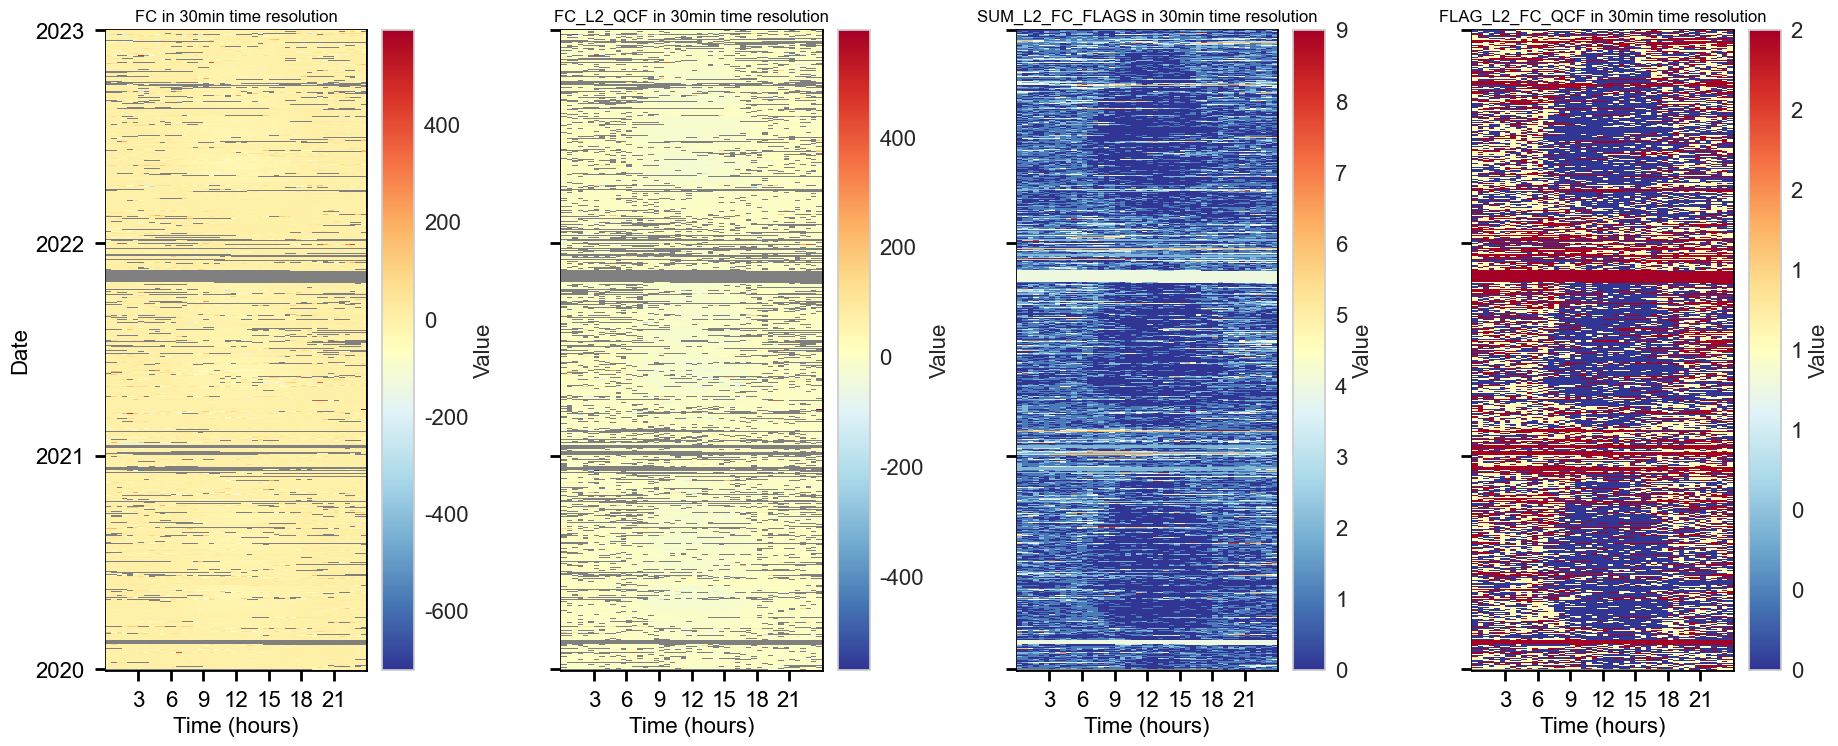

In [25]:
fpc.level2_qcf.showplot_qcf_heatmaps()

In [26]:
# fpc.level2_qcf.showplot_qcf_timeseries()

</br>

### Reports

In [27]:
fpc.level2_qcf.report_qcf_evolution()



QCF FLAG EVOLUTION
This output shows the evolution of the QCF overall quality flag
when test flags are applied sequentially to the variable FC.

Number of FC records before QC: 46335
+++ FLAG_L2_FC_MISSING_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 46335 (100.00%) / flag 1: 0 (0.00%) / flag 2: 0 (0.00%)
+++ FLAG_L2_FC_SSITC_TEST rejected 5356 values (+11.56%)      TOTALS: flag 0: 23406 (50.51%) / flag 1: 17573 (37.93%) / flag 2: 5356 (11.56%)
+++ FLAG_L2_FC_COMPLETENESS_TEST rejected 13 values (+0.03%)      TOTALS: flag 0: 23389 (50.48%) / flag 1: 17577 (37.93%) / flag 2: 5369 (11.59%)
+++ FLAG_L2_FC_SCF_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 23383 (50.47%) / flag 1: 17583 (37.95%) / flag 2: 5369 (11.59%)
+++ FLAG_L2_FC_SIGNAL_STRENGTH_TEST rejected 1275 values (+2.75%)      TOTALS: flag 0: 23118 (49.89%) / flag 1: 16573 (35.77%) / flag 2: 6644 (14.34%)
+++ FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST rejected 494 values (+1.07%)      TOTALS: flag 0: 22905 (49.43%) / fla

In [28]:
fpc.level2_qcf.report_qcf_series()



SUMMARY: FLAG_L2_FC_QCF, QCF FLAG FOR FC
Between 2019-12-31 19:15 and 2023-01-01 00:45 ...
    Total flux records BEFORE quality checks: 46335 (88.06% of potential)
    Available flux records AFTER quality checks: 39180 (84.56% of total)
    Rejected flux records: 7155 (15.44% of total)
    Potential flux records: 52620
    Potential flux records missed: 6285 (11.94% of potential)



In [29]:
# fpc.level2_qcf.report_qcf_flags()

</br>

</br>

---

# STORAGE CORRECTION (Level-3.1)

- The flux storage term (single point) is added to the flux
- For some records, the storage term can be missing. In such cases, missing terms are gap-filled using random forest
- Without gap-filling the storage term, we can lose an additional e.g. 2-3% of flux data

</br>

## Run

In [30]:
fpc.level31_storage_correction(gapfill_storage_term=False)

Detected storage variable SC_SINGLE for FC.
Calculating storage-corrected flux NEE_L3.1 from flux FC and storage term SC_SINGLE ...


</br>

## Finalize Level-3.1

In [31]:
fpc.finalize_level31()

++Added new column SC_SINGLE.
++Added new column NEE_L3.1.
++Added new column NEE_L3.1_QCF (Level-3.1 with applied quality flag from Level-2).
++Added new column NEE_L3.1_QCF0 (Level-3.1 with applied quality flag from Level-2).


</br>

### Available `Level-3.1` variables
- This shows all available Level-3.1 variables for this flux

In [32]:
[x for x in fpc.fpc_df.columns if 'L3.1' in x]

['NEE_L3.1', 'NEE_L3.1_QCF', 'NEE_L3.1_QCF0']

</br>

### Plots

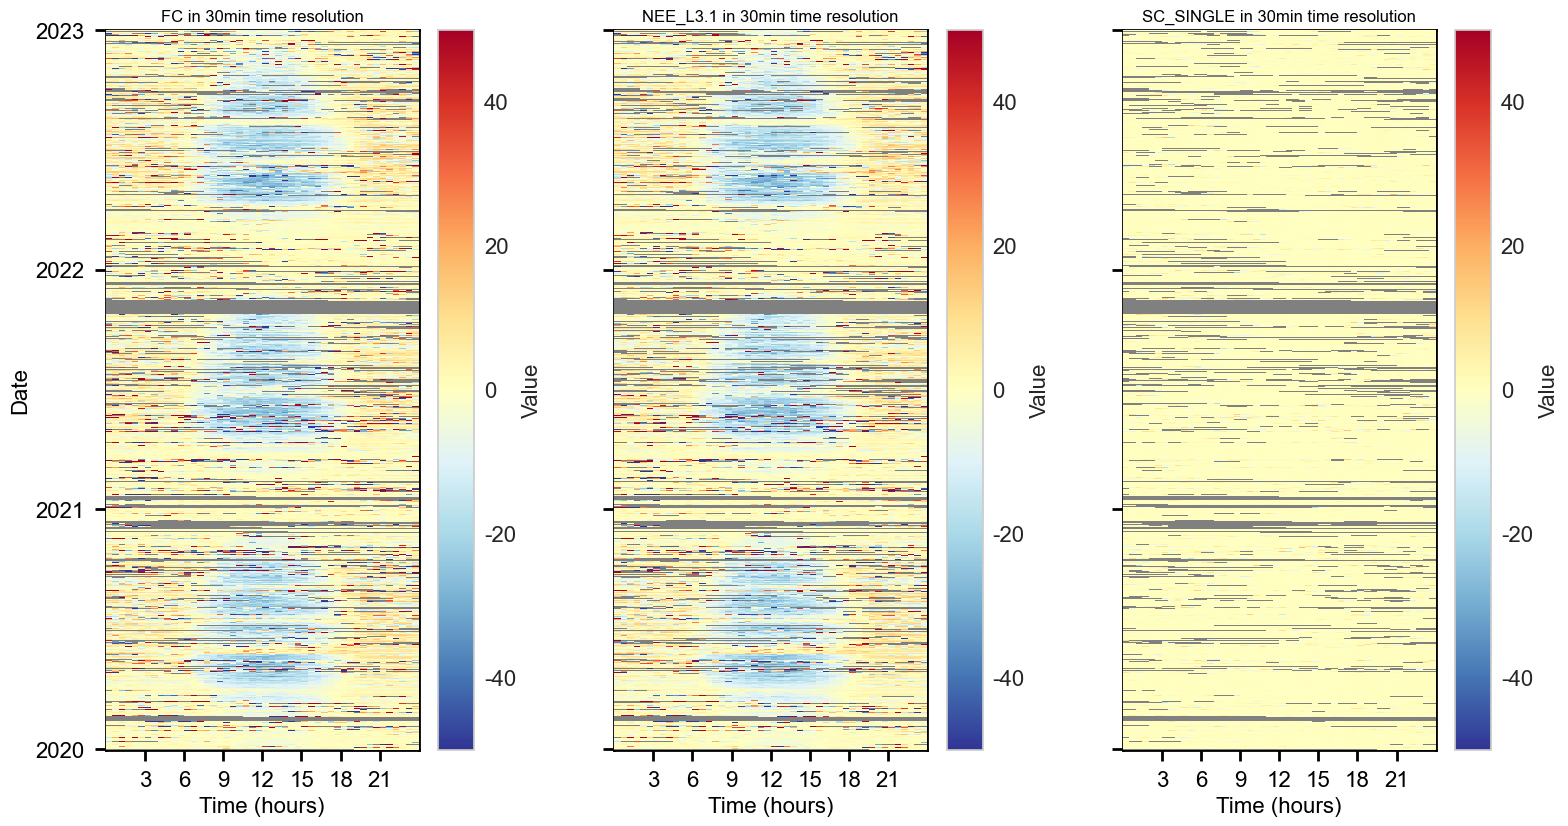

In [33]:
fpc.level31.showplot(maxflux=50)

</br>

### Report

In [34]:
fpc.level31.report()


REPORT: STORAGE CORRECTION FOR FC
Swiss FluxNet processing chain, _L3.1: Storage Correction

The gap-filled storage term None was added to flux FC.
The storage-corrected flux was stored as NEE_L3.1.

The flux was available for 46335 records (FC).
The original, non-gapfilled storage term was available for 45219 records (SC_SINGLE).
This means that the storage term SC_SINGLE is missing for 1116 measured flux (FC) records.
Without gap-filling the storage term SC_SINGLE, 1116 measured flux records (FC) are lost.

For this run, gap-filling of SC_SINGLE was - NOT SELECTED -.


</br>

</br>

---

# OUTLIER DETECTION (Level-3.2)
- Needs quality-controlled data (so far)

</br>

## Plot time series

In [35]:
print(f"{fpc.filteredseries.name} \n(quality-controlled Level-3.1 version of {fpc.fluxcol})")

NEE_L3.1_QCF 
(quality-controlled Level-3.1 version of FC)


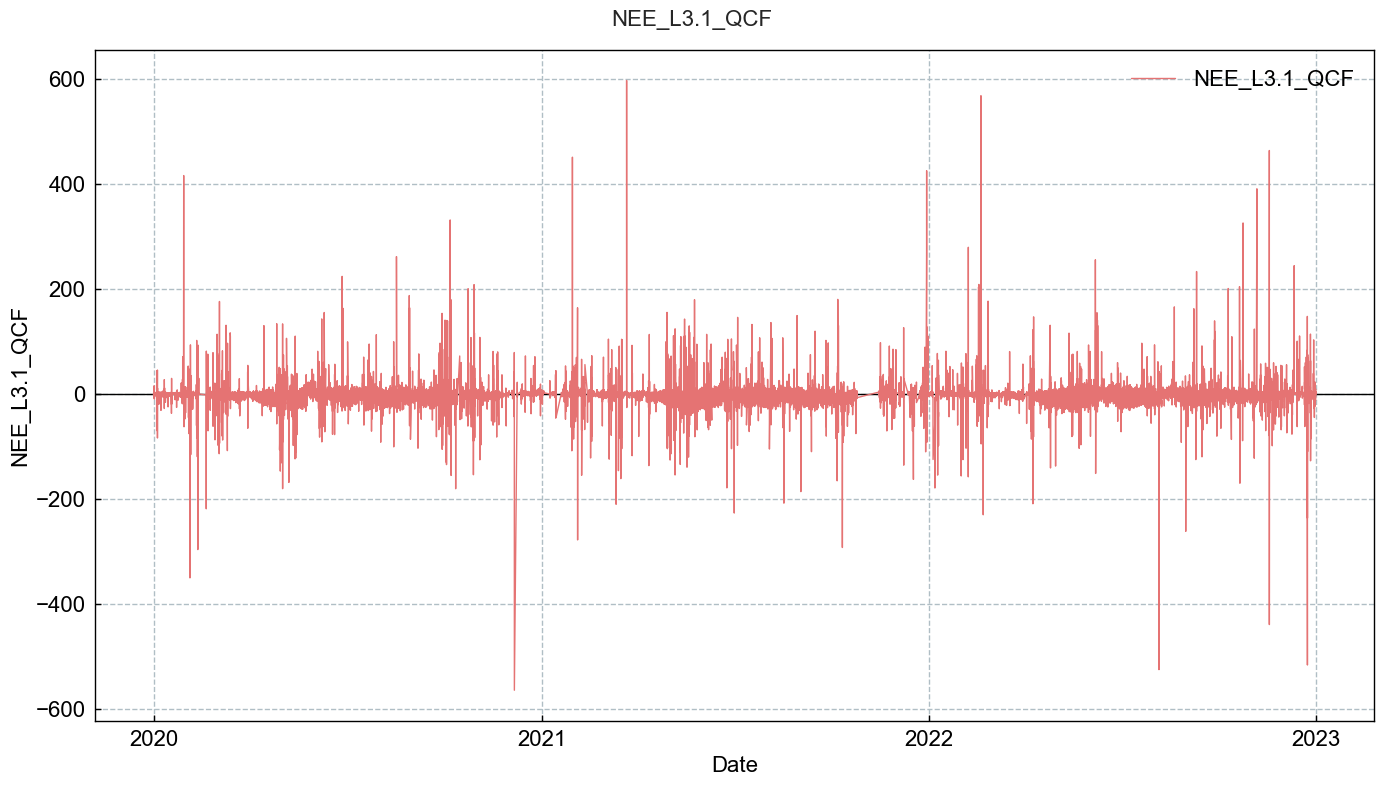

In [36]:
# TimeSeries(series=fpc.fpc_df[fpc.filteredseries.name]).plot_interactive()
TimeSeries(series=fpc.fpc_df[fpc.filteredseries.name]).plot()

</br>

## Initiate calculations

In [37]:
fpc.level32_stepwise_outlier_detection()

</br>

</br>

## Run outlier flags

</br>

### Manual flag

In [38]:
from diive.pkgs.outlierdetection.manualremoval import ManualRemoval
help(ManualRemoval)

Help on function ManualRemoval in module diive.pkgs.outlierdetection.manualremoval:

ManualRemoval(series: pandas.core.series.Series, remove_dates: list, showplot: bool = False, verbose: bool = False, idstr: str = None)
    Generate flag for data points that should be removed.



In [39]:
# fpc.level32.showplot_cleaned(interactive=True)  # True or False
# fpc.level32.showplot_cleaned(interactive=False)  # True or False



[ManualRemoval]  ManualRemoval


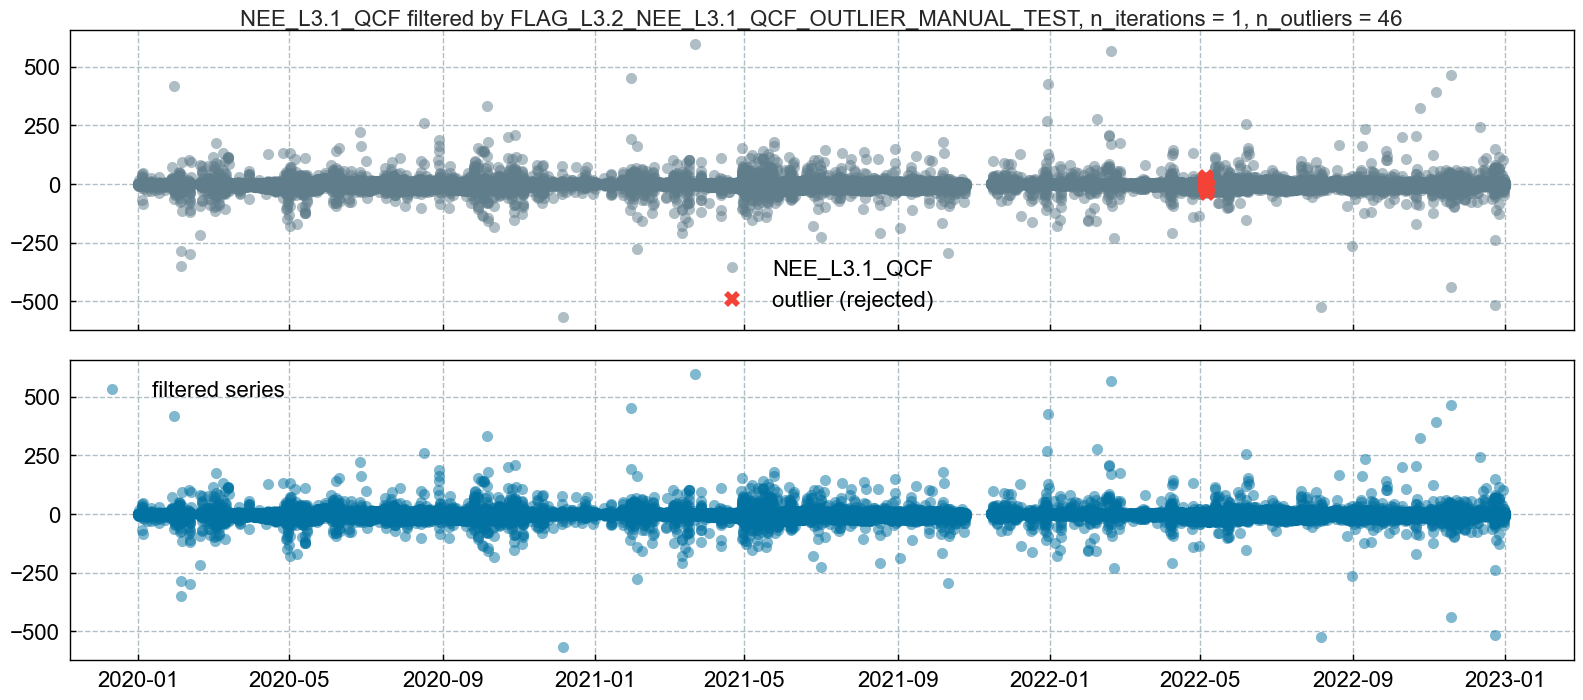

In [40]:
fpc.level32_flag_manualremoval_test(
    remove_dates=[
        ['2022-05-05 19:45:00', '2022-05-06 17:45:00'],  # Removes date range between two datetimes (inclusive)
        '2022-12-12 12:45:00'  # Removes data point with specific timestamp
    ],
    showplot=True, verbose=True)

In [41]:
fpc.level32_addflag()

++Added flag column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_MANUAL_TEST to flag data


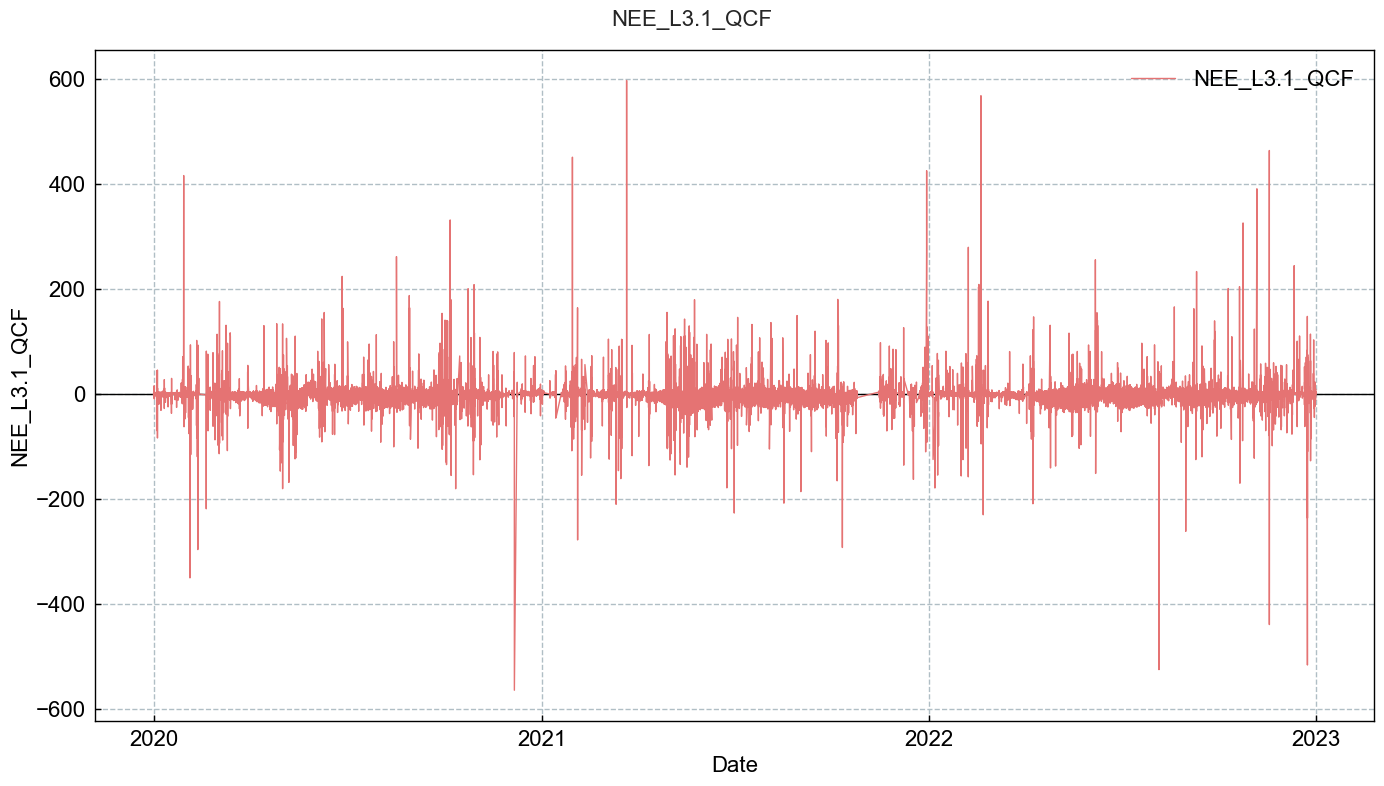

In [42]:
fpc.level32.showplot_cleaned(interactive=False)  # True or False

</br>

</br>

### z-score over all data, separate for daytime and nighttime

In [43]:
from diive.pkgs.outlierdetection.zscore import zScoreDaytimeNighttime
help(zScoreDaytimeNighttime)

Help on function zScoreDaytimeNighttime in module diive.pkgs.outlierdetection.zscore:

zScoreDaytimeNighttime(series: pandas.core.series.Series, lat: float, lon: float, utc_offset: int, idstr: str = None, thres_zscore: float = 4, showplot: bool = False, verbose: bool = False)
    # @wraps creates yet another wrapper around a decorated function that restores its type as a function
    # while preserving the docstring.
    # https://stackoverflow.com/questions/72492374/how-to-make-python-help-function-work-well-with-decorators





[zScoreDaytimeNighttime]  zScoreDaytimeNighttime
ITERATION#1: Total found outliers: 248 (daytime+nighttime), 135 (daytime), 113 (nighttime)
ITERATION#2: Total found outliers: 317 (daytime+nighttime), 130 (daytime), 187 (nighttime)
ITERATION#3: Total found outliers: 203 (daytime+nighttime), 63 (daytime), 140 (nighttime)
ITERATION#4: Total found outliers: 97 (daytime+nighttime), 23 (daytime), 74 (nighttime)
ITERATION#5: Total found outliers: 42 (daytime+nighttime), 3 (daytime), 39 (nighttime)
ITERATION#6: Total found outliers: 18 (daytime+nighttime), 0 (daytime), 18 (nighttime)
ITERATION#7: Total found outliers: 12 (daytime+nighttime), 0 (daytime), 12 (nighttime)
ITERATION#8: Total found outliers: 7 (daytime+nighttime), 0 (daytime), 7 (nighttime)
ITERATION#9: Total found outliers: 4 (daytime+nighttime), 0 (daytime), 4 (nighttime)
ITERATION#10: Total found outliers: 1 (daytime+nighttime), 0 (daytime), 1 (nighttime)
ITERATION#11: Total found outliers: 0 (daytime+nighttime), 0 (daytime), 

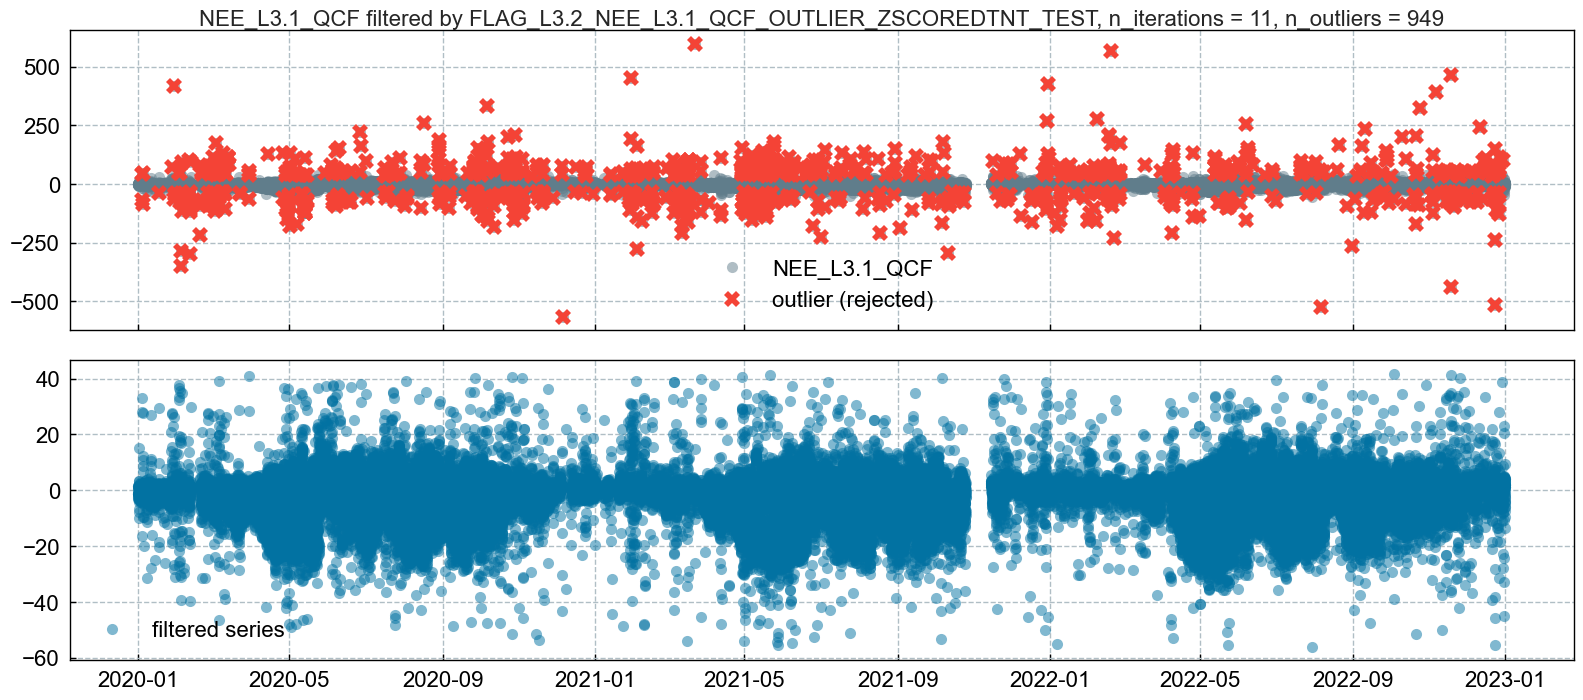

In [44]:
fpc.level32_flag_outliers_zscore_dtnt_test(thres_zscore=5, showplot=True, verbose=True, repeat=True)

In [45]:
fpc.level32_addflag()

++Added flag column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_ZSCOREDTNT_TEST to flag data


</br>

### Local standard deviation

In [46]:
from diive.pkgs.outlierdetection.localsd import LocalSD
help(LocalSD)

Help on function LocalSD in module diive.pkgs.outlierdetection.localsd:

LocalSD(series: pandas.core.series.Series, idstr: str = None, n_sd: float = 7, winsize: int = None, showplot: bool = False, verbose: bool = False)
    # @wraps creates yet another wrapper around a decorated function that restores its type as a function
    # while preserving the docstring.
    # https://stackoverflow.com/questions/72492374/how-to-make-python-help-function-work-well-with-decorators





[LocalSD]  LocalSD
ITERATION#1: Total found outliers: 233 values
ITERATION#2: Total found outliers: 130 values
ITERATION#3: Total found outliers: 79 values
ITERATION#4: Total found outliers: 49 values
ITERATION#5: Total found outliers: 28 values
ITERATION#6: Total found outliers: 16 values
ITERATION#7: Total found outliers: 6 values
ITERATION#8: Total found outliers: 4 values
ITERATION#9: Total found outliers: 1 values
ITERATION#10: Total found outliers: 0 values


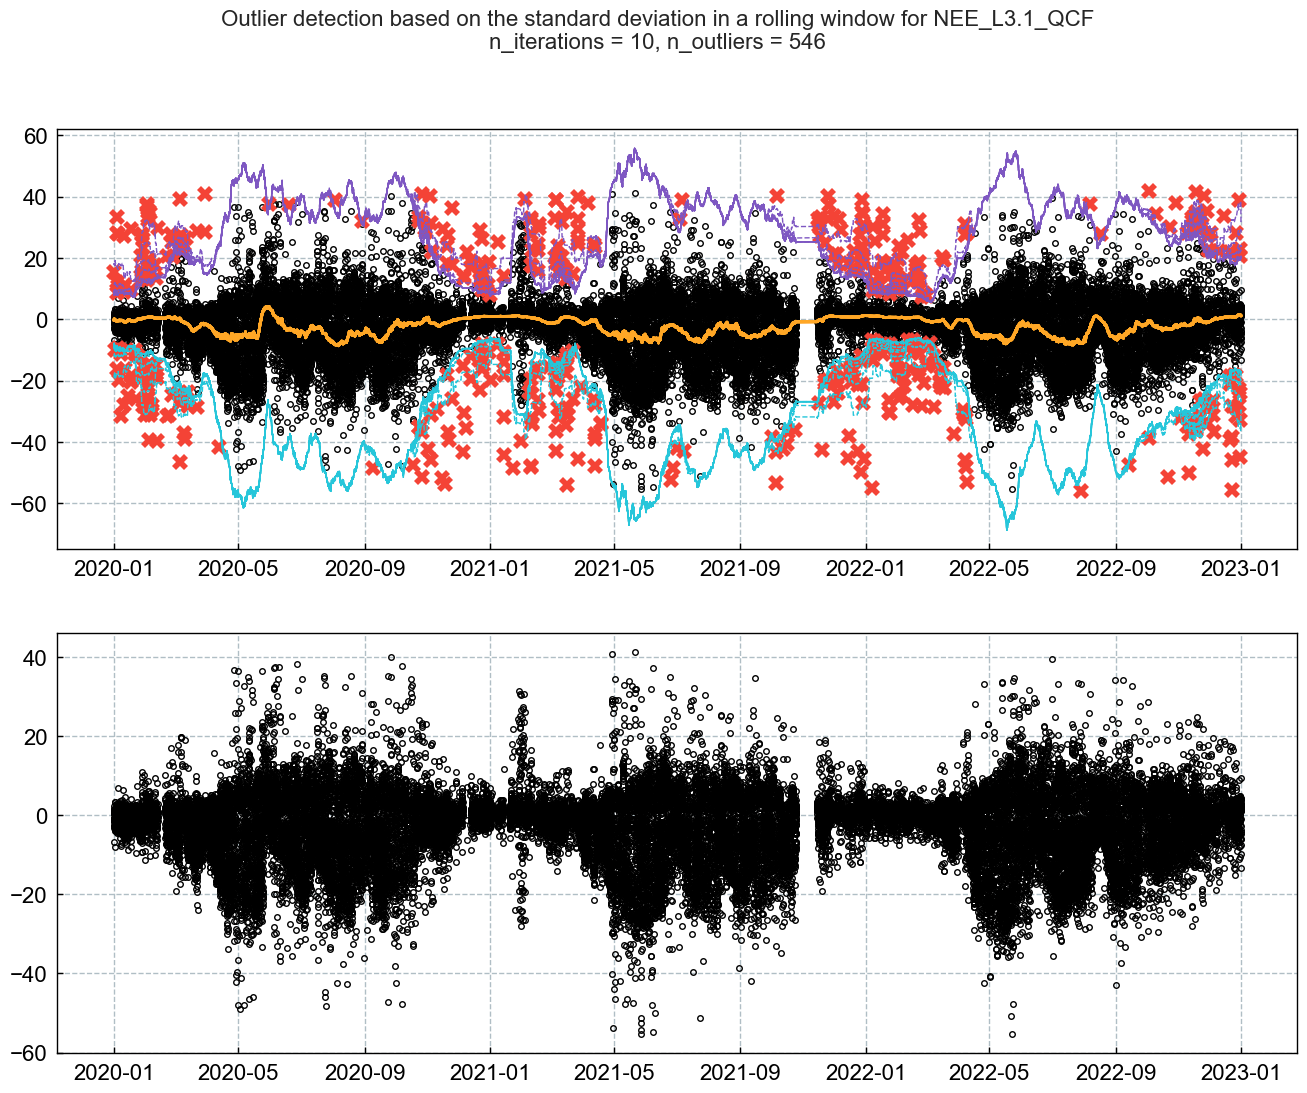

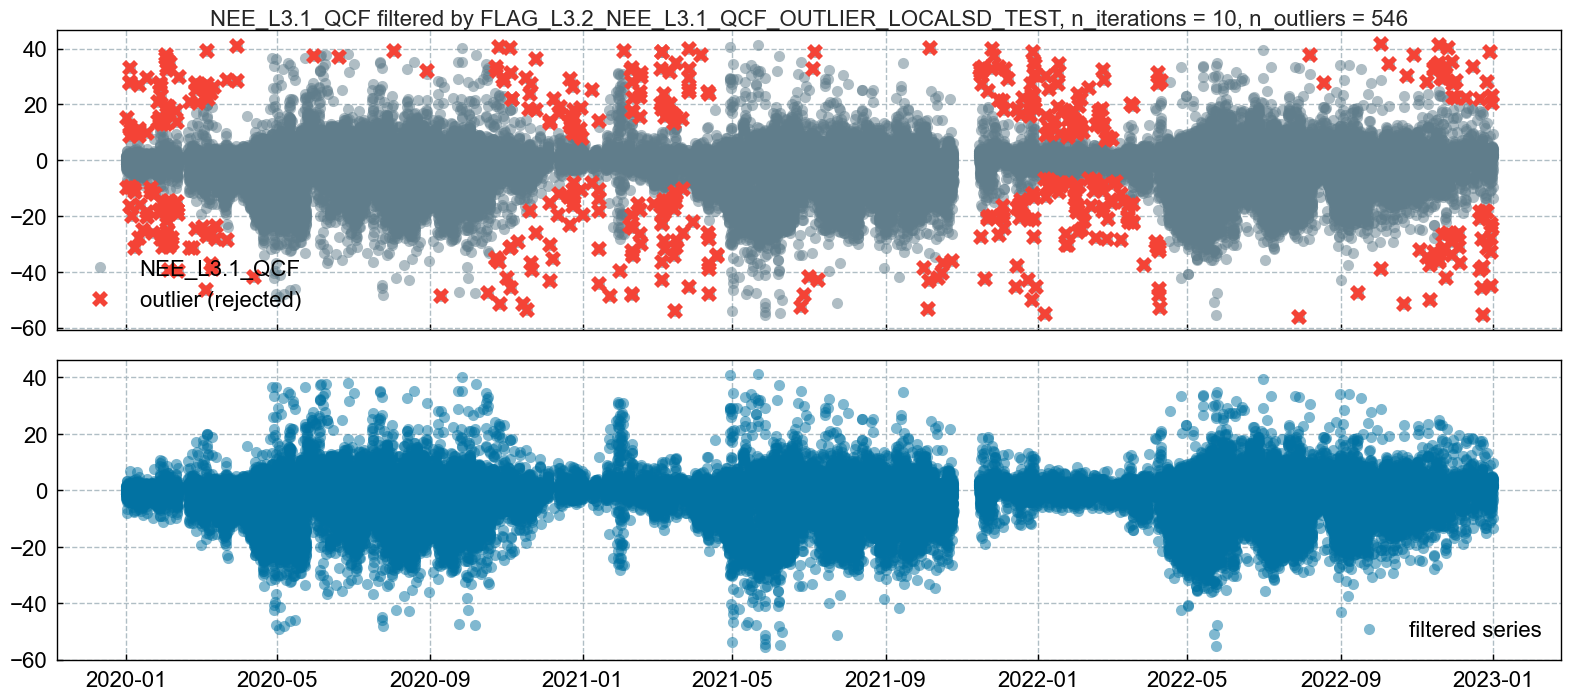

In [47]:
fpc.level32_flag_outliers_localsd_test(n_sd=4, winsize=480, showplot=True, verbose=True, repeat=True)

In [48]:
fpc.level32_addflag()

++Added flag column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_LOCALSD_TEST to flag data


</br>

</br>

### Increments z-score

In [49]:
from diive.pkgs.outlierdetection.incremental import zScoreIncrements
help(zScoreIncrements)

Help on function zScoreIncrements in module diive.pkgs.outlierdetection.incremental:

zScoreIncrements(series: pandas.core.series.Series, idstr: str = None, thres_zscore: float = 4, showplot: bool = False, verbose: bool = False)
    # @wraps creates yet another wrapper around a decorated function that restores its type as a function
    # while preserving the docstring.
    # https://stackoverflow.com/questions/72492374/how-to-make-python-help-function-work-well-with-decorators





[zScoreIncrements]  zScoreIncrements


[zScore]  zScore
ITERATION#1: Total found INCREMENT outliers: 333 values (daytime+nighttime)


[zScore]  zScore
ITERATION#2: Total found INCREMENT outliers: 231 values (daytime+nighttime)


[zScore]  zScore
ITERATION#3: Total found INCREMENT outliers: 98 values (daytime+nighttime)


[zScore]  zScore
ITERATION#4: Total found INCREMENT outliers: 45 values (daytime+nighttime)


[zScore]  zScore
ITERATION#5: Total found INCREMENT outliers: 17 values (daytime+nighttime)


[zScore]  zScore
ITERATION#6: Total found INCREMENT outliers: 11 values (daytime+nighttime)


[zScore]  zScore
ITERATION#7: Total found INCREMENT outliers: 6 values (daytime+nighttime)


[zScore]  zScore
ITERATION#8: Total found INCREMENT outliers: 1 values (daytime+nighttime)


[zScore]  zScore
ITERATION#9: Total found INCREMENT outliers: 0 values (daytime+nighttime)


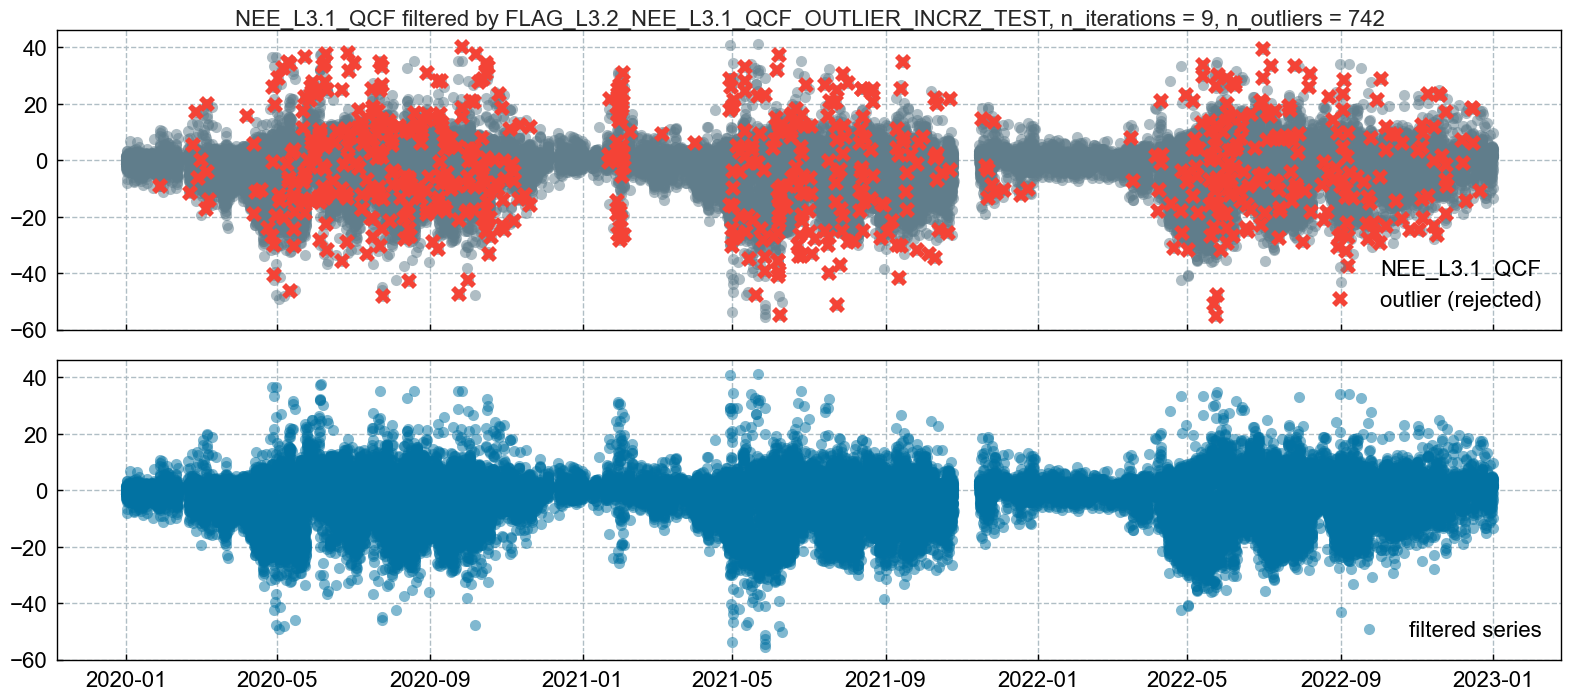

In [50]:
fpc.level32_flag_outliers_increments_zcore_test(thres_zscore=4, showplot=True, verbose=True, repeat=True)

In [51]:
fpc.level32_addflag()

++Added flag column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_INCRZ_TEST to flag data


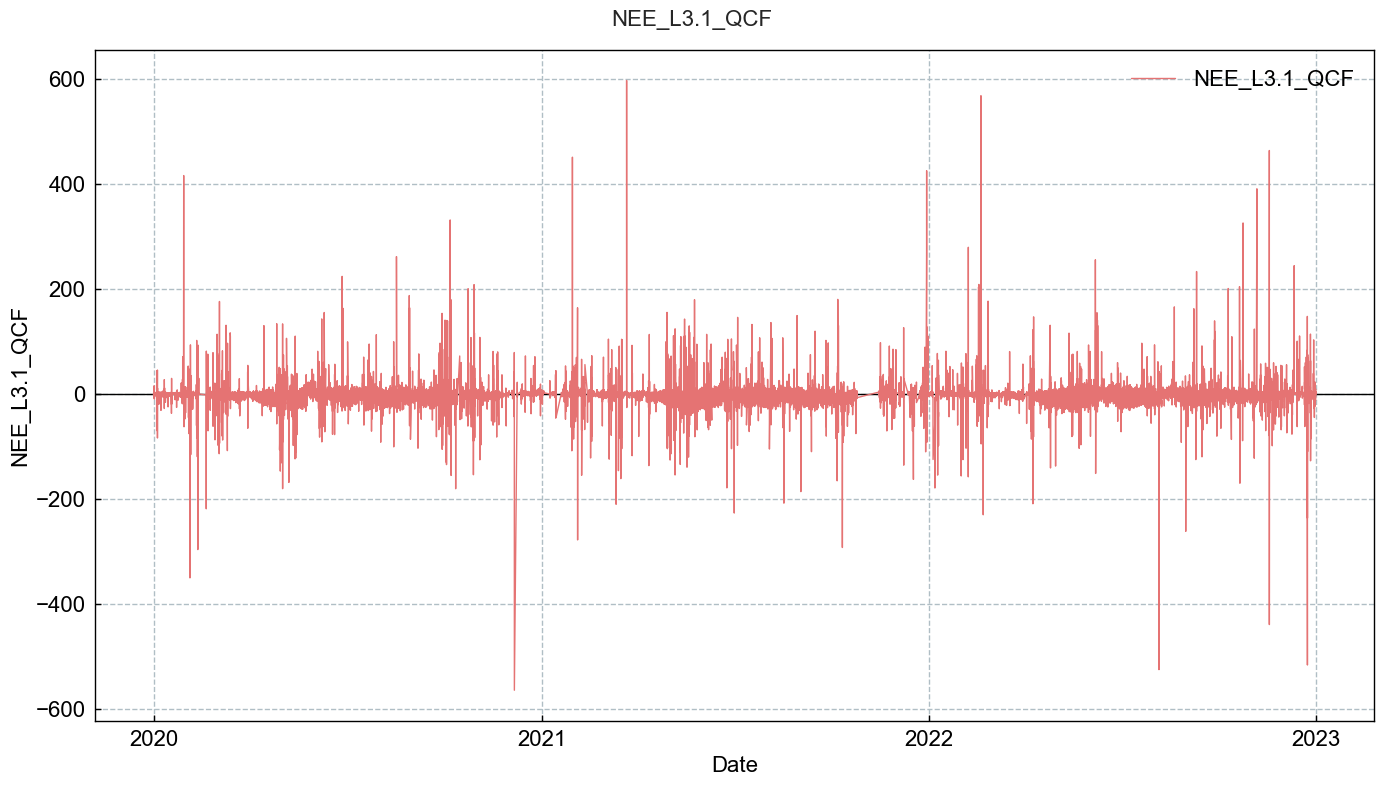

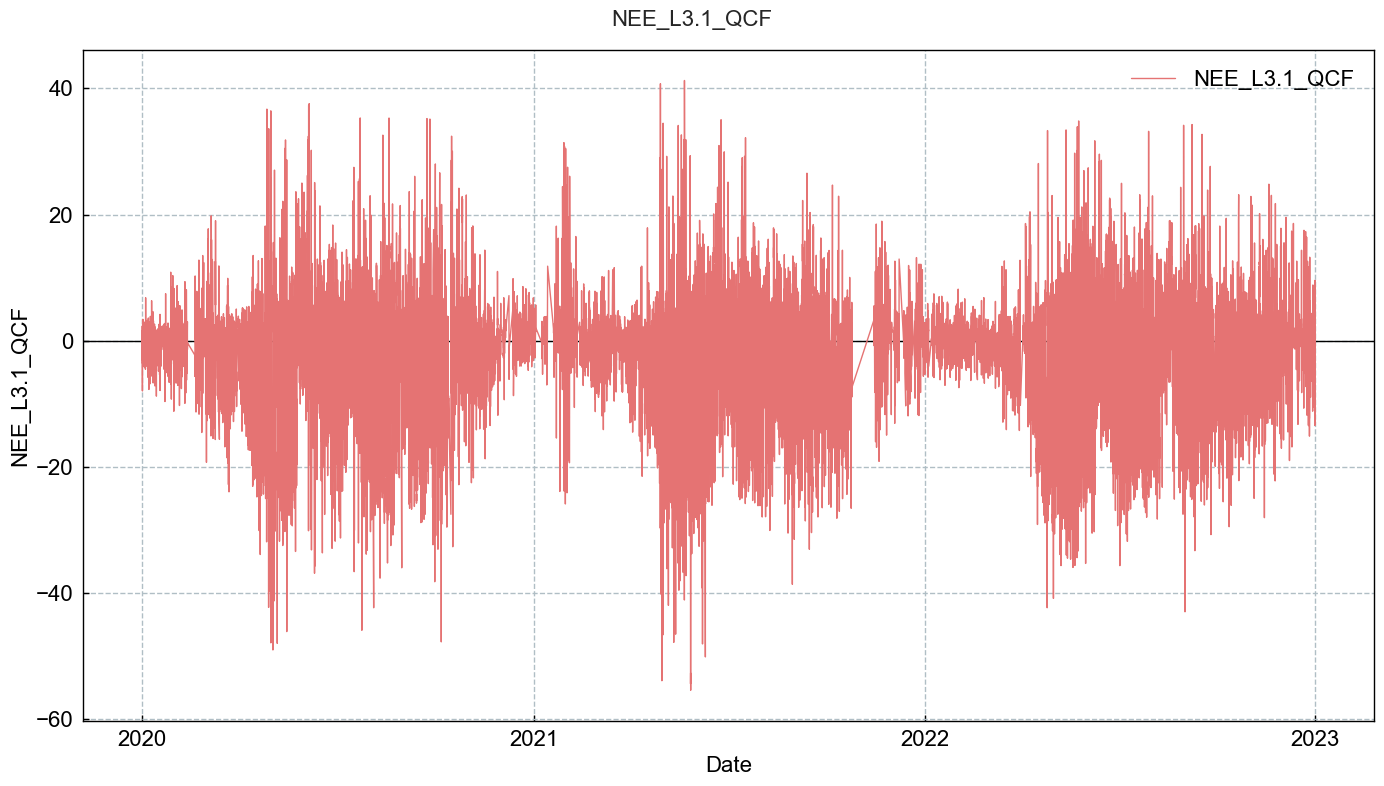

In [52]:
fpc.level32.showplot_orig()
fpc.level32.showplot_cleaned()

</br>

</br>

### Local outlier factor, daytime/nighttime

In [53]:
from diive.pkgs.outlierdetection.lof import LocalOutlierFactorDaytimeNighttime
help(LocalOutlierFactorDaytimeNighttime)

Help on function LocalOutlierFactorDaytimeNighttime in module diive.pkgs.outlierdetection.lof:

LocalOutlierFactorDaytimeNighttime(series: pandas.core.series.Series, lat: float, lon: float, utc_offset: int, idstr: str = None, n_neighbors: int = 20, contamination: float = 0.01, showplot: bool = False, verbose: bool = False, n_jobs: int = 1)
    # @wraps creates yet another wrapper around a decorated function that restores its type as a function
    # while preserving the docstring.
    # https://stackoverflow.com/questions/72492374/how-to-make-python-help-function-work-well-with-decorators





[LocalOutlierFactorDaytimeNighttime]  LocalOutlierFactorDaytimeNighttime
ITERATION#1
Total found outliers: 16 values (daytime)
Total found outliers: 9 values (nighttime)
Total found outliers: 25 values (daytime+nighttime)


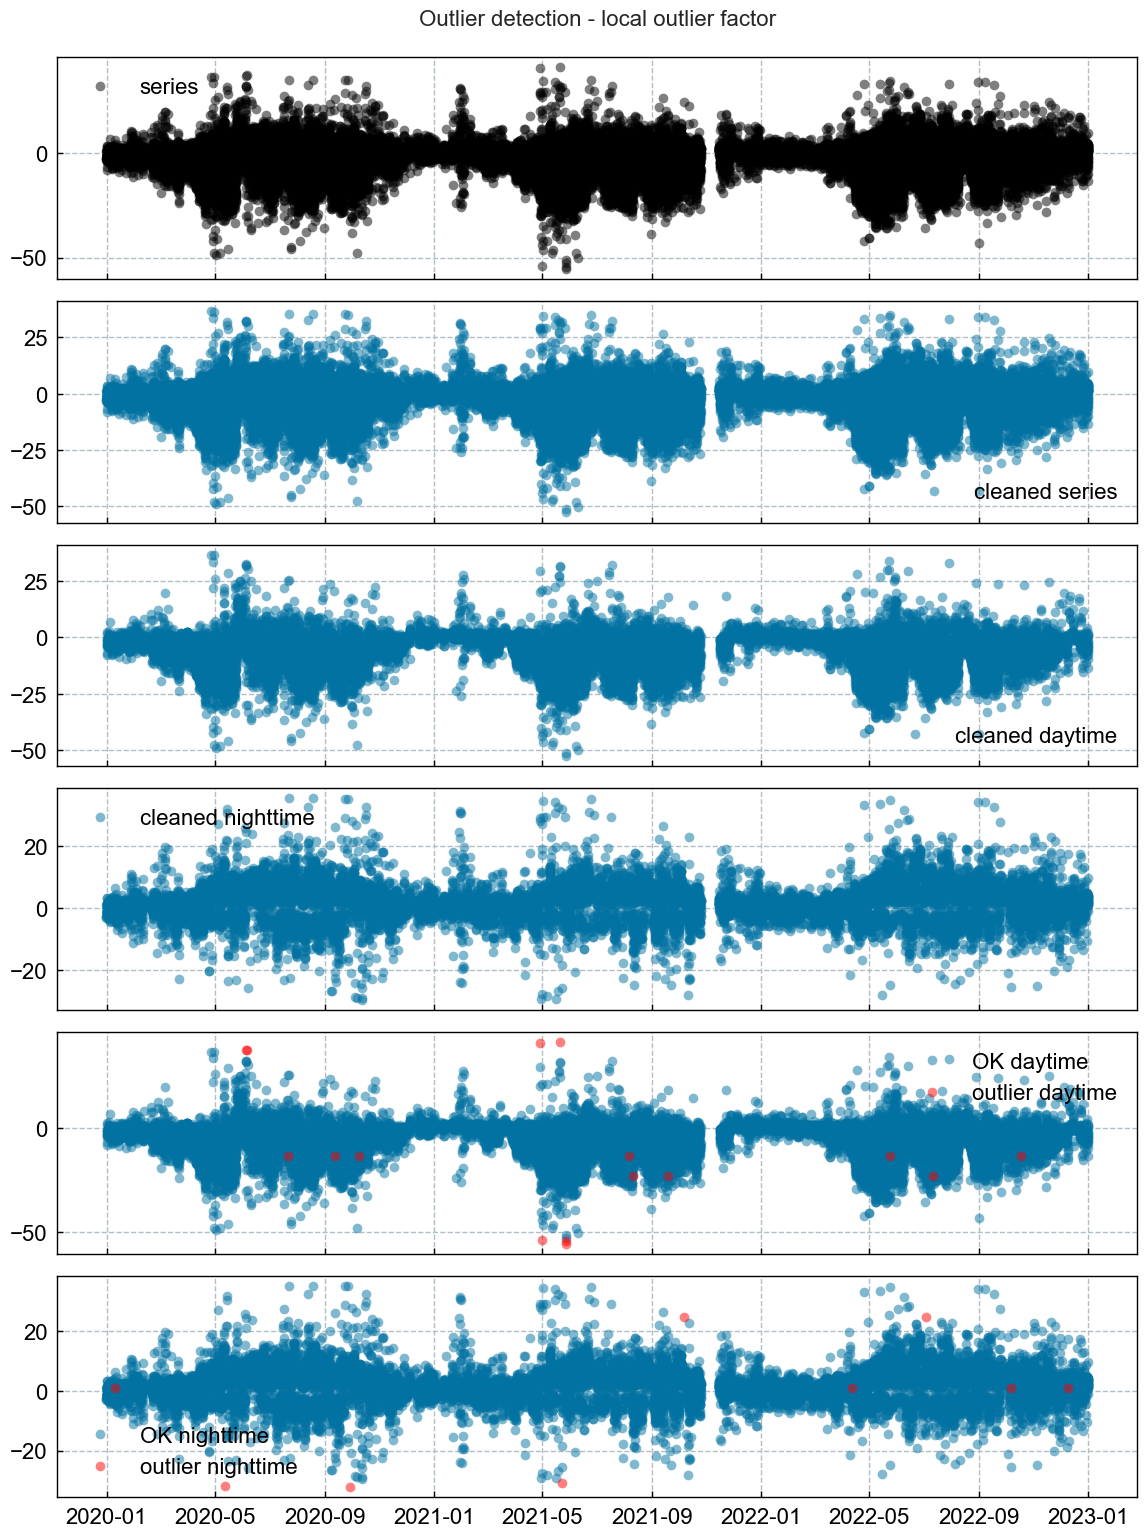

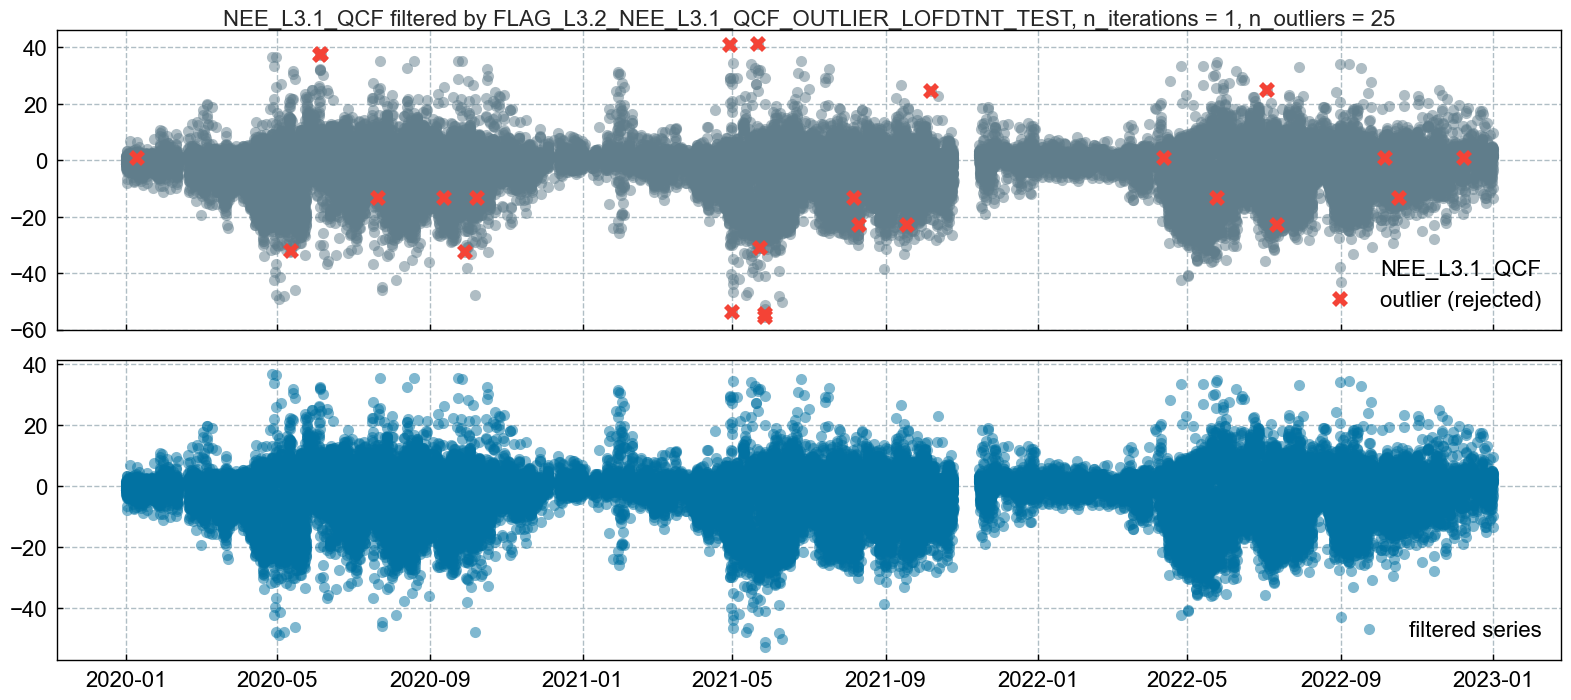

In [54]:
fpc.level32_flag_outliers_lof_dtnt_test(n_neighbors=20, contamination=None, showplot=True, verbose=True, repeat=False, n_jobs=-1)

In [55]:
fpc.level32_addflag()

++Added flag column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_LOFDTNT_TEST to flag data


</br>

</br>

### Local outlier factor

In [56]:
from diive.pkgs.outlierdetection.lof import LocalOutlierFactorAllData
help(LocalOutlierFactorAllData)

Help on function LocalOutlierFactorAllData in module diive.pkgs.outlierdetection.lof:

LocalOutlierFactorAllData(series: pandas.core.series.Series, idstr: str = None, n_neighbors: int = 20, contamination: float = 0.01, showplot: bool = False, verbose: bool = False, n_jobs: int = 1)
    # @wraps creates yet another wrapper around a decorated function that restores its type as a function
    # while preserving the docstring.
    # https://stackoverflow.com/questions/72492374/how-to-make-python-help-function-work-well-with-decorators





[LocalOutlierFactorAllData]  LocalOutlierFactorAllData
ITERATION#1: Total found outliers: 11 values (daytime+nighttime)


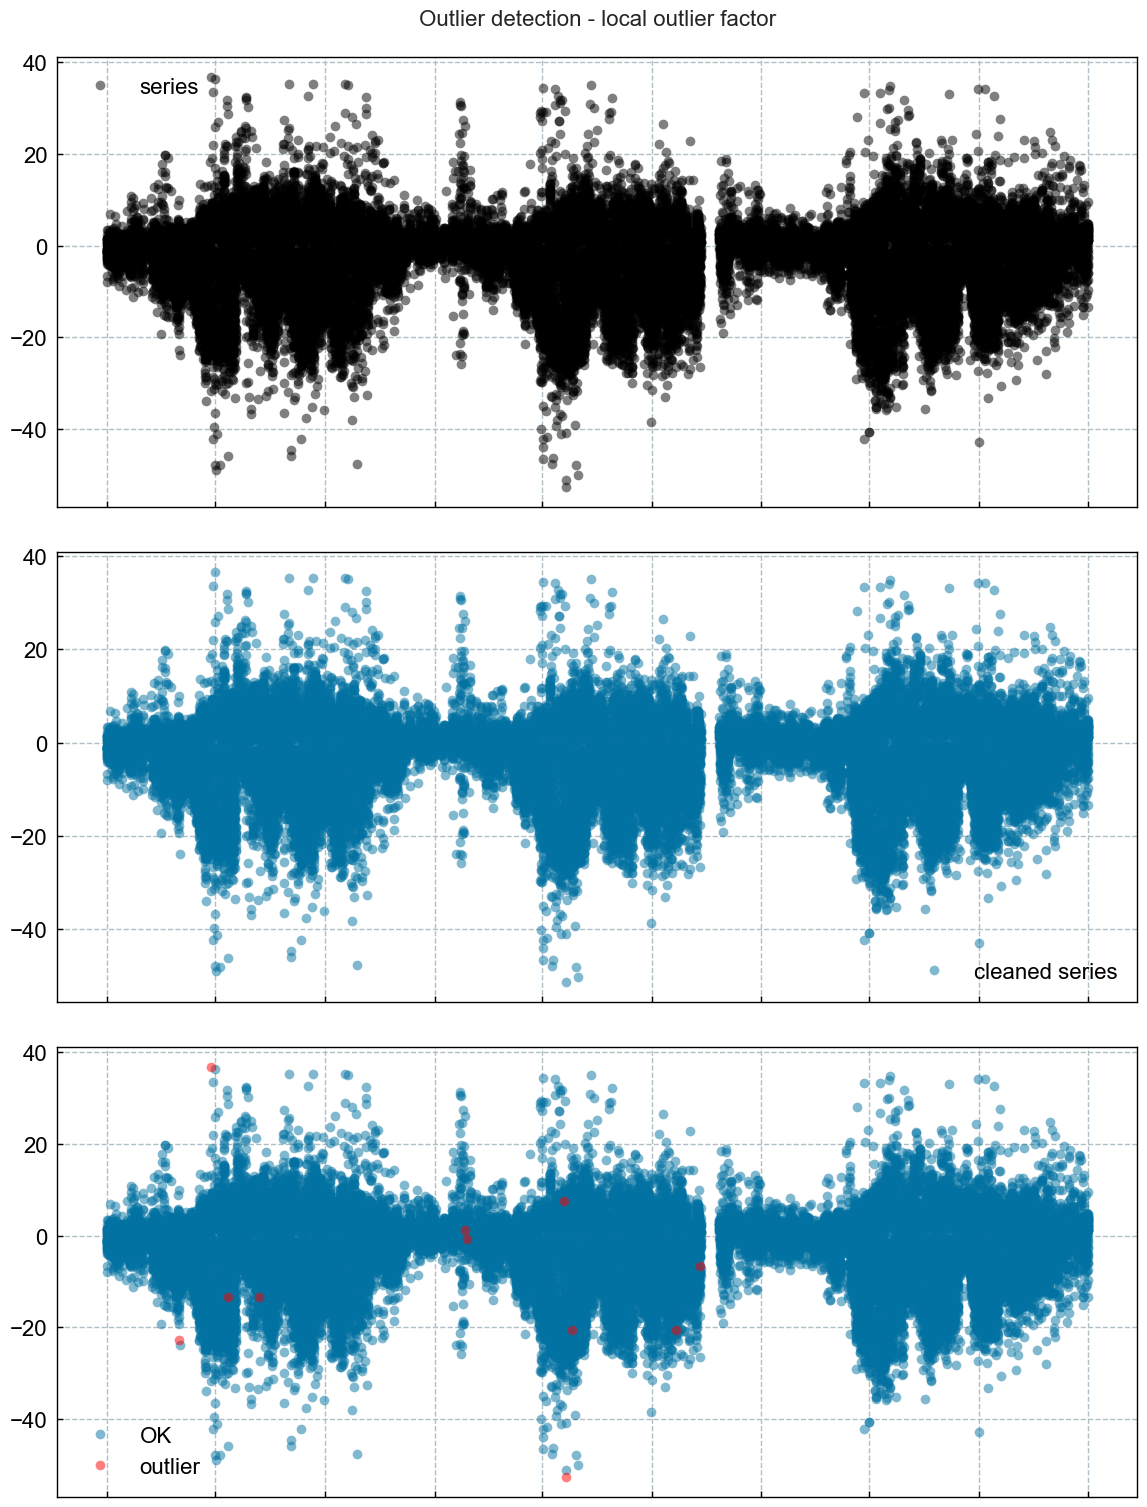

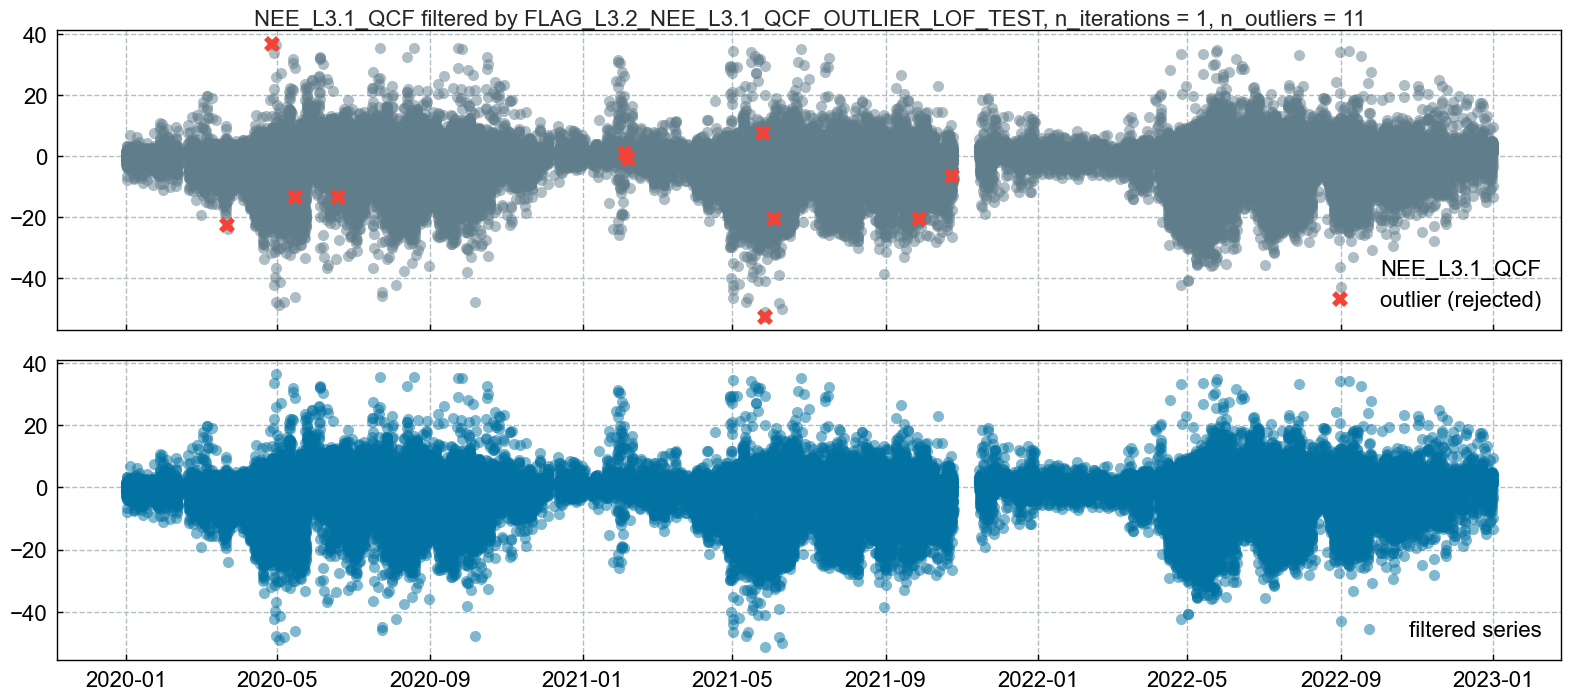

In [57]:
fpc.level32_flag_outliers_lof_test(n_neighbors=20, contamination=None, showplot=True, verbose=True, repeat=False, n_jobs=-1)

In [58]:
fpc.level32_addflag()

++Added flag column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_LOF_TEST to flag data


</br>

</br>

### z-score over all data

In [59]:
from diive.pkgs.outlierdetection.zscore import zScore
help(zScore)

Help on function zScore in module diive.pkgs.outlierdetection.zscore:

zScore(series: pandas.core.series.Series, idstr: str = None, thres_zscore: float = 4, showplot: bool = False, plottitle: str = None, verbose: bool = False)
    # @wraps creates yet another wrapper around a decorated function that restores its type as a function
    # while preserving the docstring.
    # https://stackoverflow.com/questions/72492374/how-to-make-python-help-function-work-well-with-decorators





[zScore]  zScore
ITERATION#1: Total found outliers: 10 values
ITERATION#2: Total found outliers: 1 values
ITERATION#3: Total found outliers: 0 values


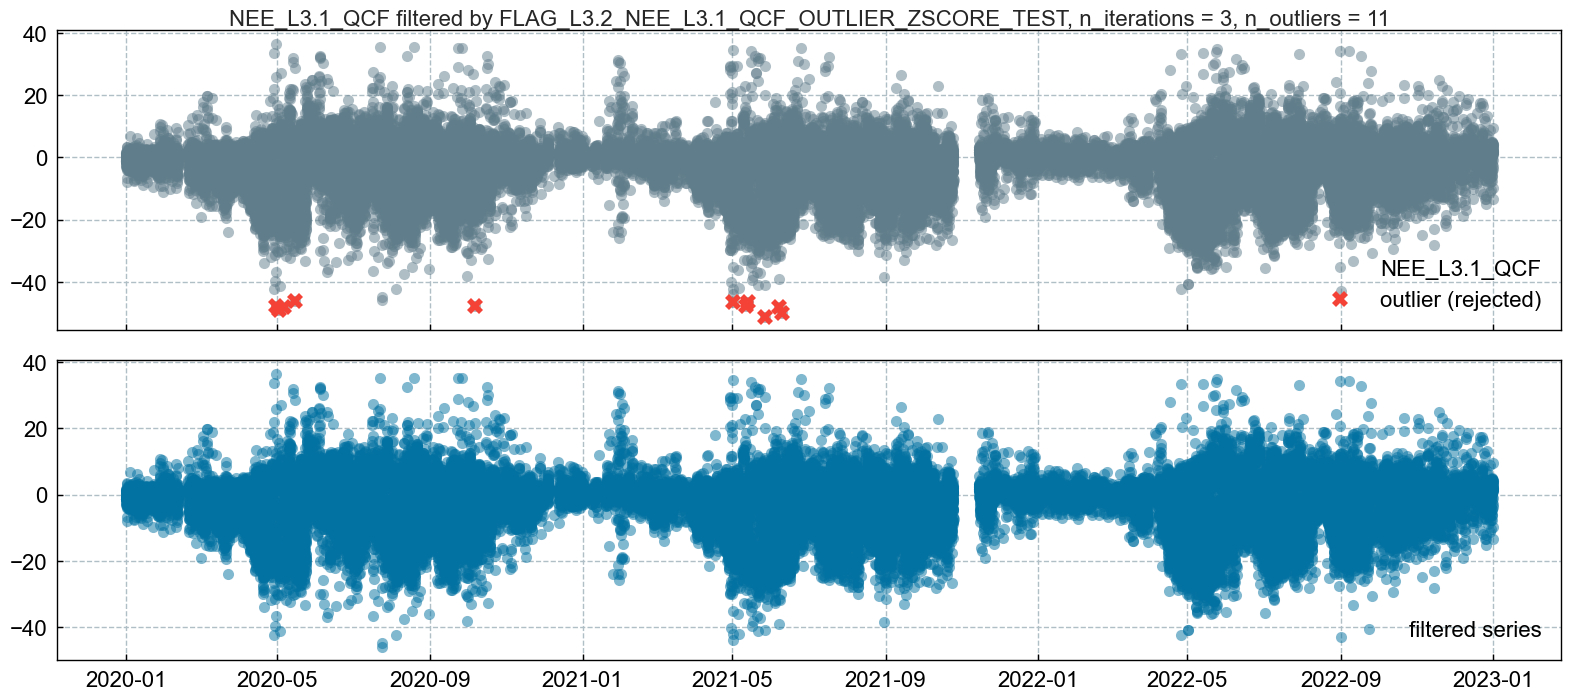

In [60]:
fpc.level32_flag_outliers_zscore_test(thres_zscore=5, showplot=True, verbose=True, repeat=True)

In [61]:
fpc.level32_addflag()

++Added flag column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_ZSCORE_TEST to flag data


</br>

</br>

### Absolute limits

In [62]:
from diive.pkgs.outlierdetection.absolutelimits import AbsoluteLimits
help(AbsoluteLimits)

Help on function AbsoluteLimits in module diive.pkgs.outlierdetection.absolutelimits:

AbsoluteLimits(series: pandas.core.series.Series, minval: float, maxval: float, idstr: str = None, showplot: bool = False, verbose: bool = False)
    Generate flag that indicates if values in data are outside
    the specified range, defined by providing the allowed minimum and
    maximum for values in *series*.





[AbsoluteLimits]  AbsoluteLimits


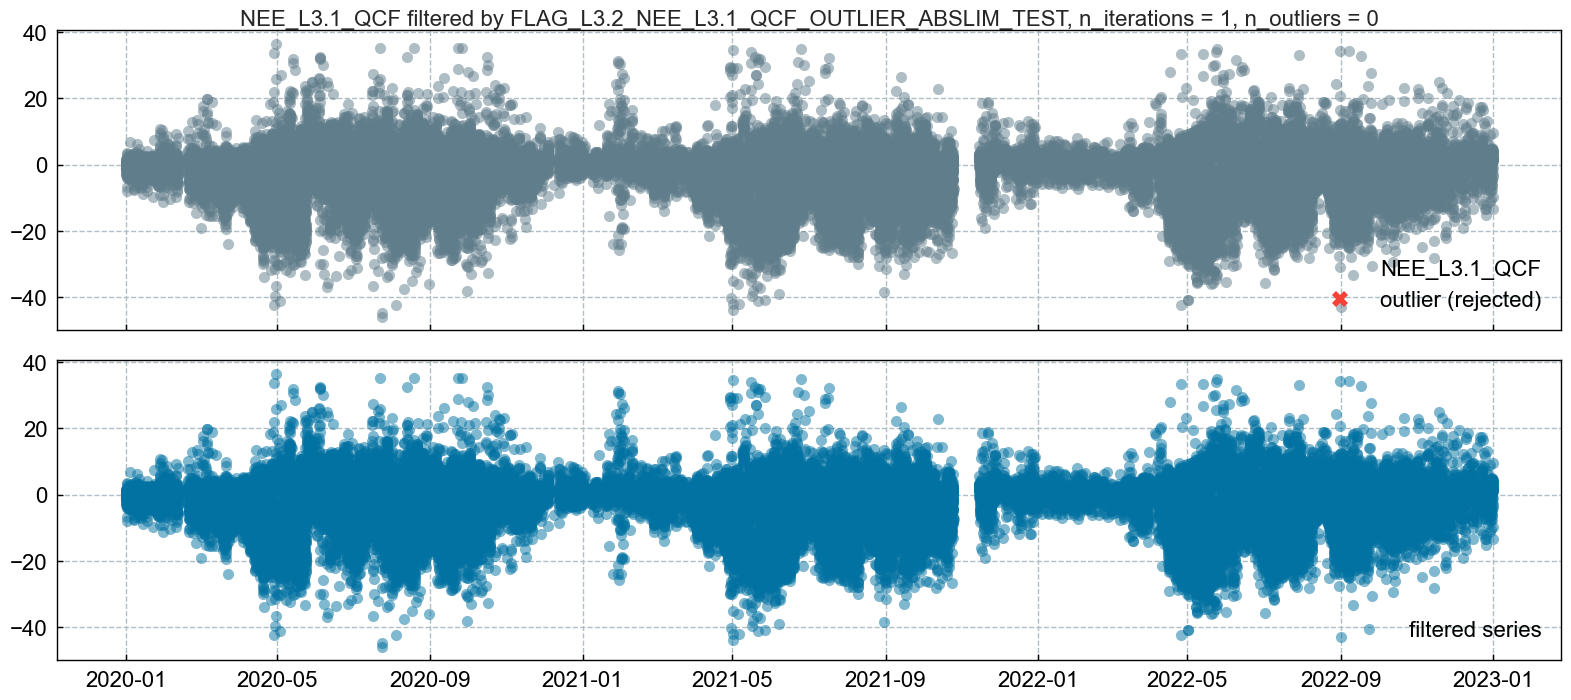

In [63]:
MIN = -50
MAX = 50
fpc.level32_flag_outliers_abslim_test(minval=-50, maxval=50, showplot=True, verbose=True)

In [64]:
fpc.level32_addflag()

++Added flag column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_ABSLIM_TEST to flag data


</br>

</br>

### Absolute limits, separate for daytime and nighttime data

In [65]:
from diive.pkgs.outlierdetection.absolutelimits import AbsoluteLimitsDaytimeNighttime
help(AbsoluteLimitsDaytimeNighttime)

Help on function AbsoluteLimitsDaytimeNighttime in module diive.pkgs.outlierdetection.absolutelimits:

AbsoluteLimitsDaytimeNighttime(series: pandas.core.series.Series, lat: float, lon: float, utc_offset: int, daytime_minmax: list, nighttime_minmax: list, idstr: str = None, showplot: bool = False, verbose: bool = False)
    Generate flag that indicates if values in data are outside
    the specified range, defined by providing allowed minimum and
    maximum values, separately for daytime and nighttime data.





[AbsoluteLimitsDaytimeNighttime]  AbsoluteLimitsDaytimeNighttime


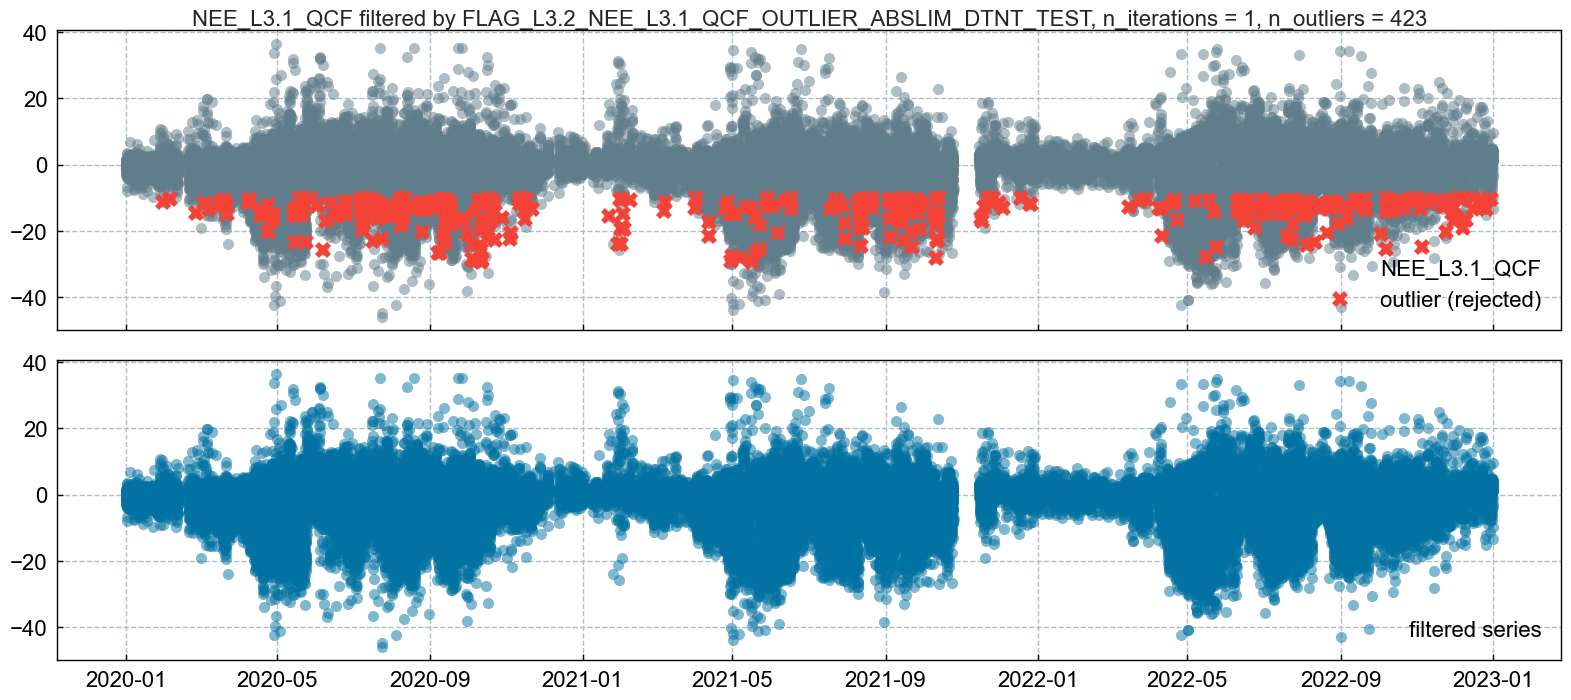

In [66]:
MIN_DT = -50
MAX_DT = 50
MIN_NT = -10
MAX_NT = 50
fpc.level32_flag_outliers_abslim_dtnt_test(daytime_minmax=[-50, 50], nighttime_minmax=[-10, 50], showplot=True, verbose=True)

In [67]:
fpc.level32_addflag()

++Added flag column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_ABSLIM_DTNT_TEST to flag data


</br>

</br>

## Finalize Level-3.2

In [68]:
fpc.finalize_level32(nighttime_threshold=50, daytime_accept_qcf_below=2, nighttimetime_accept_qcf_below=2)

++Added new column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_MANUAL_TEST.
++Added new column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_ZSCOREDTNT_TEST.
++Added new column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_LOCALSD_TEST.
++Added new column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_INCRZ_TEST.
++Added new column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_LOFDTNT_TEST.
++Added new column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_LOF_TEST.
++Added new column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_ZSCORE_TEST.
++Added new column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_ABSLIM_TEST.
++Added new column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_ABSLIM_DTNT_TEST.
++Added new column SUM_L3.2_NEE_L3.1_HARDFLAGS.
++Added new column SUM_L3.2_NEE_L3.1_SOFTFLAGS.
++Added new column SUM_L3.2_NEE_L3.1_FLAGS.
++Added new column FLAG_L3.2_NEE_L3.1_QCF.
++Added new column NEE_L3.1_L3.2_QCF.
++Added new column NEE_L3.1_L3.2_QCF0.


</br>

### Available `Level-3.2` variables
- This shows all available Level-3.2 variables for this flux

In [69]:
[x for x in fpc.fpc_df.columns if 'L3.2' in x]

['FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_MANUAL_TEST',
 'FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_ZSCOREDTNT_TEST',
 'FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_LOCALSD_TEST',
 'FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_INCRZ_TEST',
 'FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_LOFDTNT_TEST',
 'FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_LOF_TEST',
 'FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_ZSCORE_TEST',
 'FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_ABSLIM_TEST',
 'FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_ABSLIM_DTNT_TEST',
 'SUM_L3.2_NEE_L3.1_HARDFLAGS',
 'SUM_L3.2_NEE_L3.1_SOFTFLAGS',
 'SUM_L3.2_NEE_L3.1_FLAGS',
 'FLAG_L3.2_NEE_L3.1_QCF',
 'NEE_L3.1_L3.2_QCF',
 'NEE_L3.1_L3.2_QCF0']

</br>

### Plots

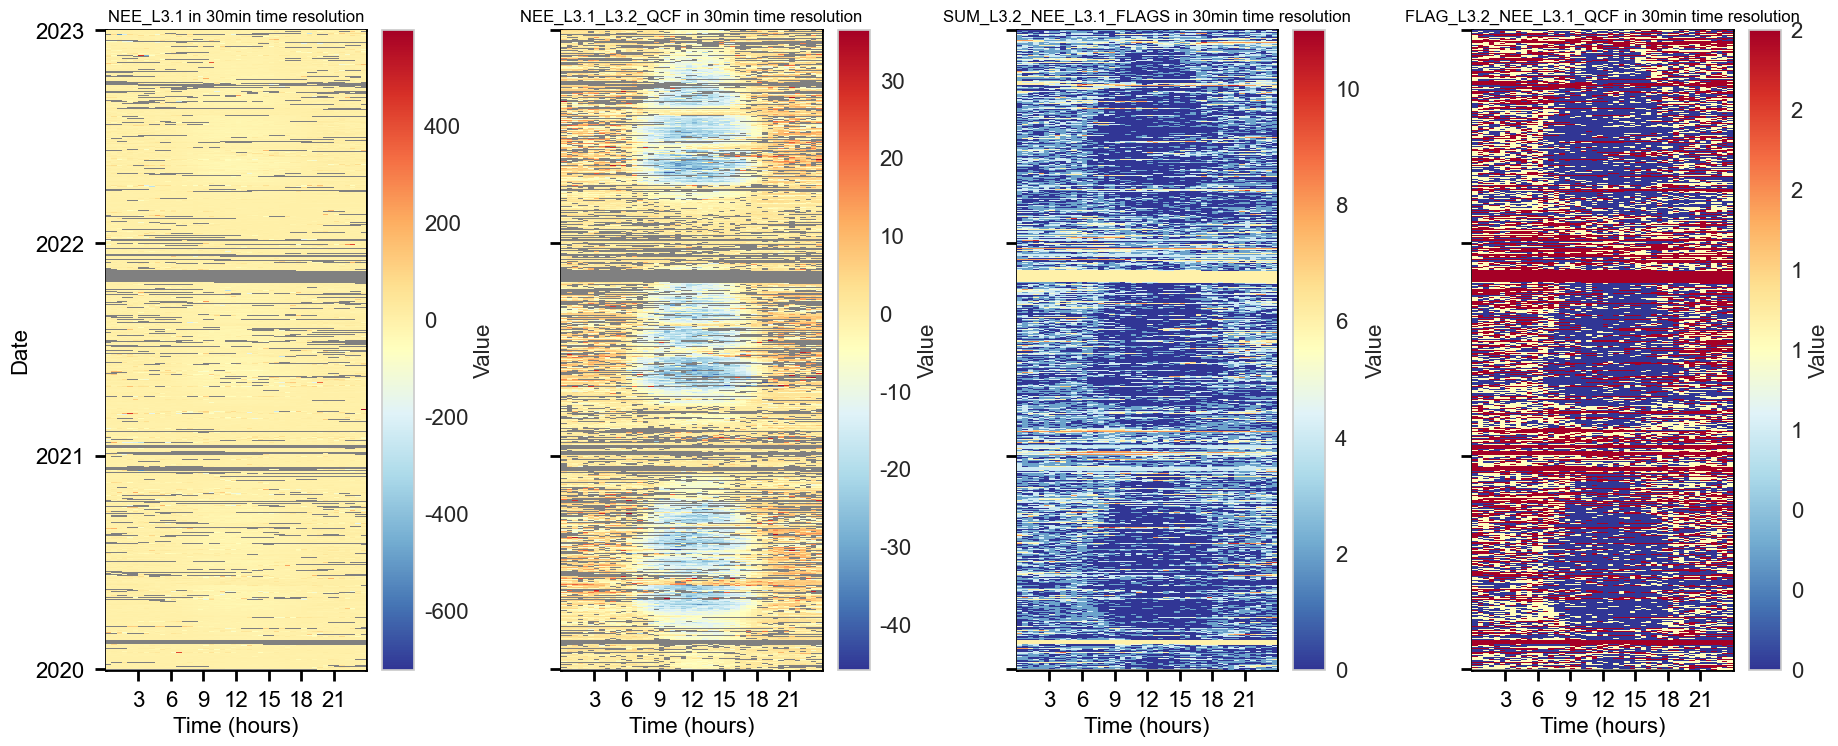

In [70]:
fpc.level32_qcf.showplot_qcf_heatmaps()

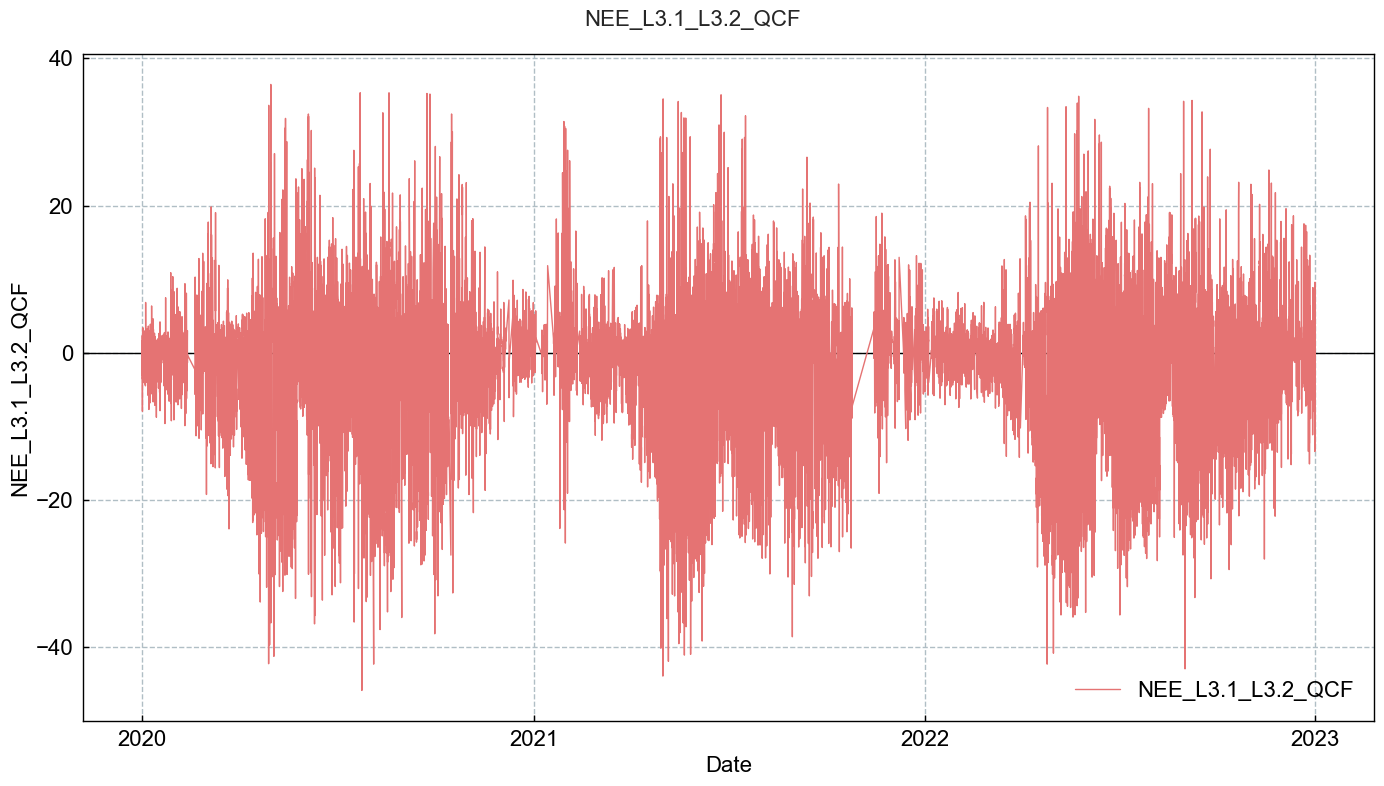

In [71]:
TimeSeries(series=fpc.filteredseries).plot()
# TimeSeries(series=fpc.filteredseries).plot_interactive()

In [72]:
# fpc.level32_qcf.showplot_qcf_timeseries()

</br>

### Reports

In [73]:
fpc.level32_qcf.report_qcf_evolution()



QCF FLAG EVOLUTION
This output shows the evolution of the QCF overall quality flag
when test flags are applied sequentially to the variable NEE_L3.1.

Number of NEE_L3.1 records before QC: 45219
+++ FLAG_L2_FC_MISSING_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 45219 (100.00%) / flag 1: 0 (0.00%) / flag 2: 0 (0.00%)
+++ FLAG_L2_FC_SSITC_TEST rejected 5005 values (+11.07%)      TOTALS: flag 0: 23203 (51.31%) / flag 1: 17011 (37.62%) / flag 2: 5005 (11.07%)
+++ FLAG_L2_FC_COMPLETENESS_TEST rejected 11 values (+0.02%)      TOTALS: flag 0: 23189 (51.28%) / flag 1: 17014 (37.63%) / flag 2: 5016 (11.09%)
+++ FLAG_L2_FC_SCF_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 23183 (51.27%) / flag 1: 17020 (37.64%) / flag 2: 5016 (11.09%)
+++ FLAG_L2_FC_SIGNAL_STRENGTH_TEST rejected 1122 values (+2.48%)      TOTALS: flag 0: 22939 (50.73%) / flag 1: 16142 (35.70%) / flag 2: 6138 (13.57%)
+++ FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST rejected 490 values (+1.08%)      TOTALS: flag 0: 22729 (5

In [74]:
fpc.level32_qcf.report_qcf_series()



SUMMARY: FLAG_L3.2_NEE_L3.1_QCF, QCF FLAG FOR NEE_L3.1
Between 2019-12-31 19:15 and 2023-01-01 00:45 ...
    Total flux records BEFORE quality checks: 45219 (85.94% of potential)
    Available flux records AFTER quality checks: 35833 (79.24% of total)
    Rejected flux records: 9386 (20.76% of total)
    Potential flux records: 52620
    Potential flux records missed: 7401 (14.06% of potential)



In [75]:
# fpc.level32_qcf.report_qcf_flags()

</br>

</br>

# Add results to main data

In [76]:
print(f"Currently the main dataframe has {len(maindf.columns)} variables.")
print(f"The flux processing chain dataframe with new results has {len(fpc.fpc_df.columns)} variables for flux {FLUXVAR}.")

Currently the main dataframe has 485 variables.
The flux processing chain dataframe with new results has 37 variables for flux FC.


In [77]:
_maindf = maindf.copy()  # Make a copy so we can restart this step directly from here, in case something goes wrong further down, better safe than sorry
print(f"Preparing to add new results to main data, checking for new variables:")
newcols = [c for c in fpc.fpc_df.columns if c not in _maindf.columns]
print(f"In total, {len(newcols)} new variables will be added back to the main data.")
[print(f"--> Found new variable {col} in new results.") for col in newcols];

Preparing to add new results to main data, checking for new variables:
In total, 34 new variables will be added back to the main data.
--> Found new variable DAYTIME in new results.
--> Found new variable NIGHTTIME in new results.
--> Found new variable FLAG_L2_FC_MISSING_TEST in new results.
--> Found new variable FLAG_L2_FC_SSITC_TEST in new results.
--> Found new variable FLAG_L2_FC_COMPLETENESS_TEST in new results.
--> Found new variable FLAG_L2_FC_SCF_TEST in new results.
--> Found new variable FLAG_L2_FC_SIGNAL_STRENGTH_TEST in new results.
--> Found new variable FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST in new results.
--> Found new variable FLAG_L2_FC_CO2_VM97_AMPLITUDE_RESOLUTION_HF_TEST in new results.
--> Found new variable FLAG_L2_FC_CO2_VM97_DROPOUT_TEST in new results.
--> Found new variable SUM_L2_FC_HARDFLAGS in new results.
--> Found new variable SUM_L2_FC_SOFTFLAGS in new results.
--> Found new variable SUM_L2_FC_FLAGS in new results.
--> Found new variable FLAG_L2_FC_QCF in 

In [78]:
_maindf = pd.concat([_maindf, fpc.fpc_df[newcols]], axis=1)
print(f"New variables were added to main data.")
print(f"The main dataframe now has {len(_maindf.columns)} variables.")

New variables were added to main data.
The main dataframe now has 519 variables.


</br>

</br>

# Overview after `Level-3.2`

</br>

## Flux variable names

In [79]:
fluxes_qcf = [c for c in _maindf.columns if str(c).endswith("_QCF") and not str(c).startswith("FLAG_") and "L3.2" in c ]
fluxes_qcf0 = [c for c in _maindf.columns if str(c).endswith("_QCF0") and not str(c).startswith("FLAG_") and "L3.2" in c ]
print(f"Quality-controlled fluxes: {fluxes_qcf}")
print(f"Quality-controlled fluxes, HIGHEST QUALITY: {fluxes_qcf0}")

Quality-controlled fluxes: ['NEE_L3.1_L3.2_QCF']
Quality-controlled fluxes, HIGHEST QUALITY: ['NEE_L3.1_L3.2_QCF0']


</br>

In [80]:
FLUXVAR2QCF = fpc.filteredseries_level2_qcf.name
FLUXVAR31QCF = fpc.filteredseries_level31_qcf.name
FLUXVAR32QCF = fpc.filteredseries_level32_qcf.name
FLUXVAR32QCF_HQ = f"{FLUXVAR32QCF}0"

print("--------------------------")
print("OVERVIEW OF FLUX VARIABLES")
print("--------------------------")
print("")
print("Input flux variable:")
print(f"{FLUXVAR}")
print("")
print("Intermediate flux variables:")
print(f"  - {FLUXVAR2QCF} (quality-controlled with Level-2 flags)  -->  not used in any further processing steps")
print(f"  - {FLUXVAR31QCF} (quality-controlled with Level-2 flags, including Level-3.1 storage correction)  -->  not used in any further processing steps")
print("")
print("Important flux variables:")
print(f"  - {FLUXVAR32QCF_HQ} (HIGHEST QUALITY ONLY (QCF=0), quality-controlled with Level-2 and Level-3.2 flags, including Level-3.1 storage correction)  -->  USED FOR USTAR DETECTION")
print(f"  - {FLUXVAR32QCF} (quality-controlled with Level-2 and Level-3.2 flags, including Level-3.1 storage correction)  -->  CAN BE USED FOR BUDGETS (after USTAR application and gap-filling")

--------------------------
OVERVIEW OF FLUX VARIABLES
--------------------------

Input flux variable:
FC

Intermediate flux variables:
  - FC_L2_QCF (quality-controlled with Level-2 flags)  -->  not used in any further processing steps
  - NEE_L3.1_QCF (quality-controlled with Level-2 flags, including Level-3.1 storage correction)  -->  not used in any further processing steps

Important flux variables:
  - NEE_L3.1_L3.2_QCF0 (HIGHEST QUALITY ONLY (QCF=0), quality-controlled with Level-2 and Level-3.2 flags, including Level-3.1 storage correction)  -->  USED FOR USTAR DETECTION
  - NEE_L3.1_L3.2_QCF (quality-controlled with Level-2 and Level-3.2 flags, including Level-3.1 storage correction)  -->  CAN BE USED FOR BUDGETS (after USTAR application and gap-filling


</br>

</br>

## Plot quality-controlled flux after `Level-3.2`
- Plot flux after storage-correction, flux quality control and outlier removal

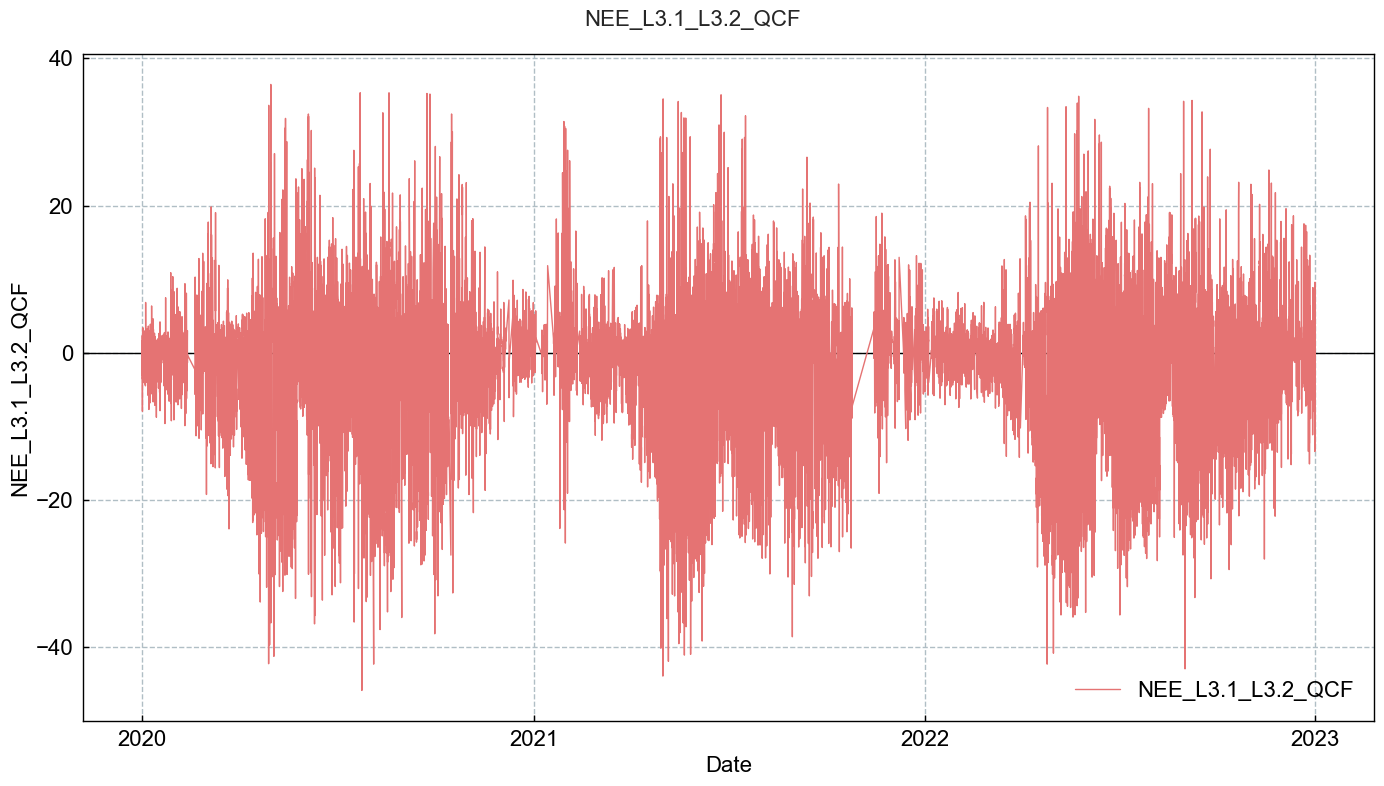

In [81]:
# TimeSeries(series=fpc.fpc_df[fluxhq]).plot_interactive()
TimeSeries(series=fpc.fpc_df[FLUXVAR32QCF]).plot()

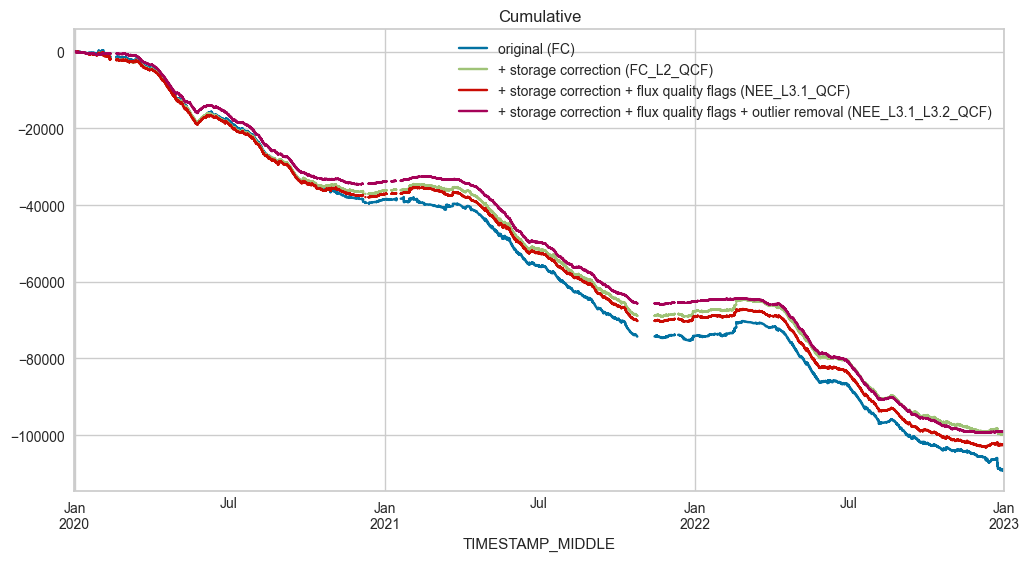

In [82]:
# Creating a dictionary by passing Series objects as values

frame = {
    f'original ({FLUXVAR})': fpc.fpc_df[FLUXVAR],
    f'+ storage correction ({FLUXVAR2QCF})': fpc.fpc_df[FLUXVAR2QCF],    
    f'+ storage correction + flux quality flags ({FLUXVAR31QCF})': fpc.fpc_df[FLUXVAR31QCF],    
    f'+ storage correction + flux quality flags + outlier removal ({FLUXVAR32QCF})': fpc.fpc_df[FLUXVAR32QCF]
}

overview = pd.DataFrame(frame)
overview.cumsum().plot(title=f"Cumulative", figsize=(12, 6));

</br>

## Comparison flux quality

In [83]:
import scipy.stats
MQ = fpc.level32_qcf.flagqcf == 1

highest_quality = _maindf[FLUXVAR32QCF_HQ].copy().dropna()
medium_quality = _maindf[FLUXVAR32QCF][MQ].copy().dropna()
medium_quality.name = f"{medium_quality.name}1"
print(scipy.stats.ttest_ind(a=highest_quality.to_numpy(), b=medium_quality.to_numpy(), equal_var=True))

TtestResult(statistic=-41.735358703026336, pvalue=0.0, df=35831.0)


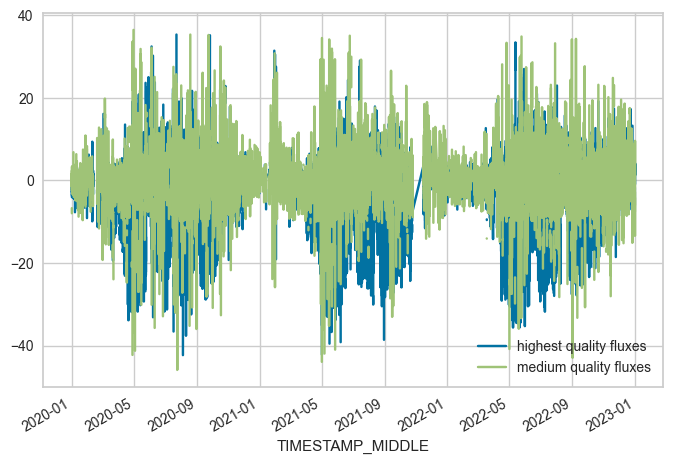

In [84]:
ab = {'highest quality fluxes': highest_quality, 'medium quality fluxes': medium_quality}
pd.DataFrame.from_dict(ab).plot();

In [85]:
pd.concat([highest_quality.describe(), medium_quality.describe()], axis=1)

NEE_L3.1_L3.2_QCF0  NEE_L3.1_L3.2_QCF1
count        22000.000000        13833.000000
mean            -4.221576           -0.443575
std              9.125367            6.916607
min            -42.289470          -45.861080
25%            -10.057370           -3.053874
50%             -2.550478           -0.078889
75%              2.020590            2.372769
max             35.325910           36.452010

</br>

## Available `Level-3.2` fluxes

In [86]:
_fluxcols = [x for x in fpc.fpc_df.columns if 'L3.1' and 'L3.2' in x and str(x).endswith('_QCF') and not str(x).startswith('FLAG_') ]
_fluxcols

['NEE_L3.1_L3.2_QCF']

In [87]:
_subset = fpc.fpc_df[_fluxcols]
_subset

NEE_L3.1_L3.2_QCF
TIMESTAMP_MIDDLE                      
2019-12-31 19:15:00                NaN
2019-12-31 19:45:00          -3.091055
2019-12-31 20:15:00          -2.743766
2019-12-31 20:45:00           1.105327
2019-12-31 21:15:00          -2.421812
...                                ...
2022-12-31 22:45:00           1.279532
2022-12-31 23:15:00                NaN
2022-12-31 23:45:00           4.065241
2023-01-01 00:15:00           2.331724
2023-01-01 00:45:00           3.976043

[52620 rows x 1 columns]

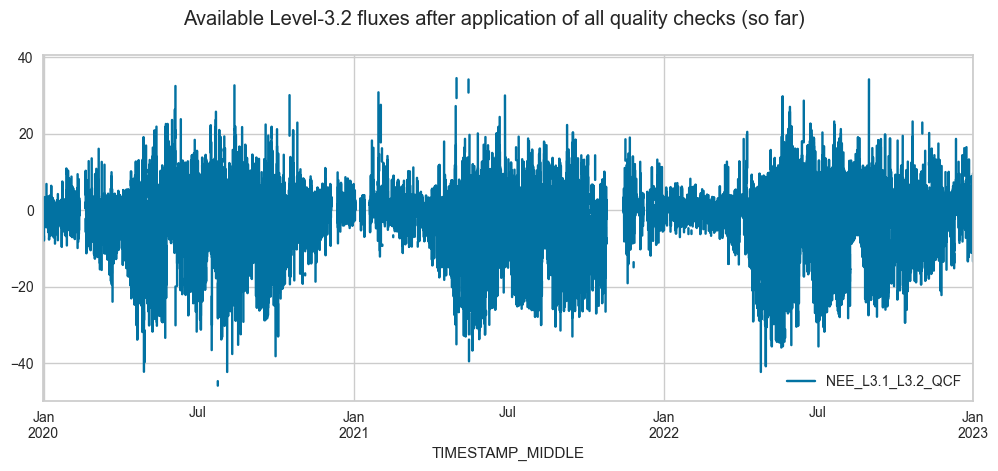

In [88]:
_subset.plot(subplots=True, title="Available Level-3.2 fluxes after application of all quality checks (so far)", figsize=(12, 4.5));

In [89]:
boxplots_df = fpc.fpc_df[[FLUXVAR32QCF, "DAYTIME"]].copy()
boxplots_df["MONTH"] = boxplots_df.index.month
boxplots_df

NEE_L3.1_L3.2_QCF  DAYTIME  MONTH
TIMESTAMP_MIDDLE                                      
2019-12-31 19:15:00                NaN      0.0     12
2019-12-31 19:45:00          -3.091055      0.0     12
2019-12-31 20:15:00          -2.743766      0.0     12
2019-12-31 20:45:00           1.105327      0.0     12
2019-12-31 21:15:00          -2.421812      0.0     12
...                                ...      ...    ...
2022-12-31 22:45:00           1.279532      0.0     12
2022-12-31 23:15:00                NaN      0.0     12
2022-12-31 23:45:00           4.065241      0.0     12
2023-01-01 00:15:00           2.331724      0.0      1
2023-01-01 00:45:00           3.976043      0.0      1

[52620 rows x 3 columns]

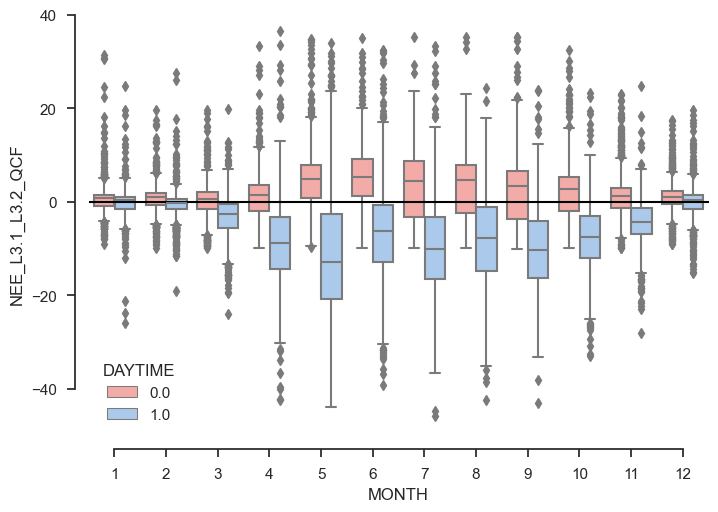

In [90]:
# Draw boxplots
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(x="MONTH", y=FLUXVAR32QCF, palette=["r", "b"], hue="DAYTIME", data=boxplots_df)
sns.despine(offset=10, trim=True)
plt.axhline(0, color="black");

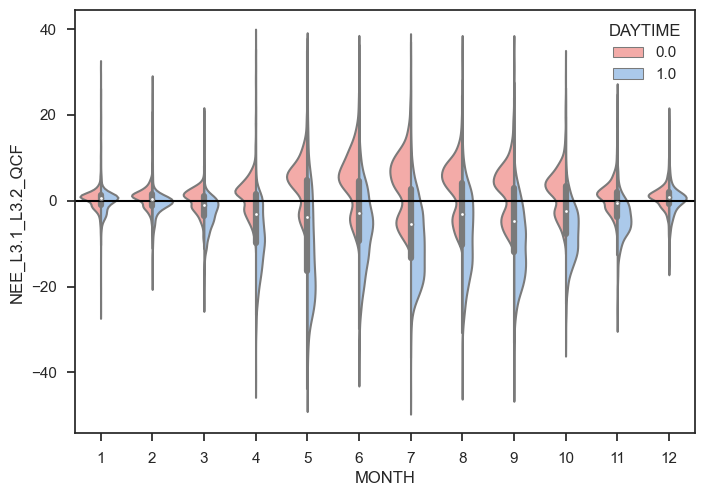

In [91]:
# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(data=boxplots_df, x="MONTH", y=FLUXVAR32QCF, hue="DAYTIME", split=True, palette=["r", "b"]);
plt.axhline(0, color="black");

</br>

</br>

# Save results to file
- Save results to file for futher processing
- This can be useful if you want to use the data in another software, e.g. continuing post-processing using the library `ReddyProc` in `R` 
- `Parquet` format is recommended for large datasets

</br>

## Option 1: Save to CSV (large and slow)

In [ ]:
_maindf.to_csv("mylovelyhorse.csv")

</br>

## Option 2: Save to Parquet (small and fast)
- Needed if you want to continue post-processing in notebooks
- Can also be used in `R` with the `arrow` package

In [ ]:
save_parquet(data=_maindf, filename="mylovelyhorse")

</br>

# *(Preliminary) USTAR*

<div class="alert alert-block alert-danger">
    No USTAR filtering for: <b>H, LE, ET and FH2O.</b> 
</div>

> The USTAR filtering is not applied to H and LE, because it has not been proved that when there are CO2 advective fluxes, these also impact energy fluxes, specifically due to the fact that when advection is in general large (nighttime), energy fluxes are small.

source: [Pastorello et al. (2020). The FLUXNET2015 dataset and the ONEFlux processing pipeline for eddy covariance data](https://doi.org/10.1038/s41597-020-0534-3)



## *(Preliminary) Impact of different USTAR thresholds on data availability*



[UstarThresholdConstantScenarios]  UstarThresholdConstantScenarios


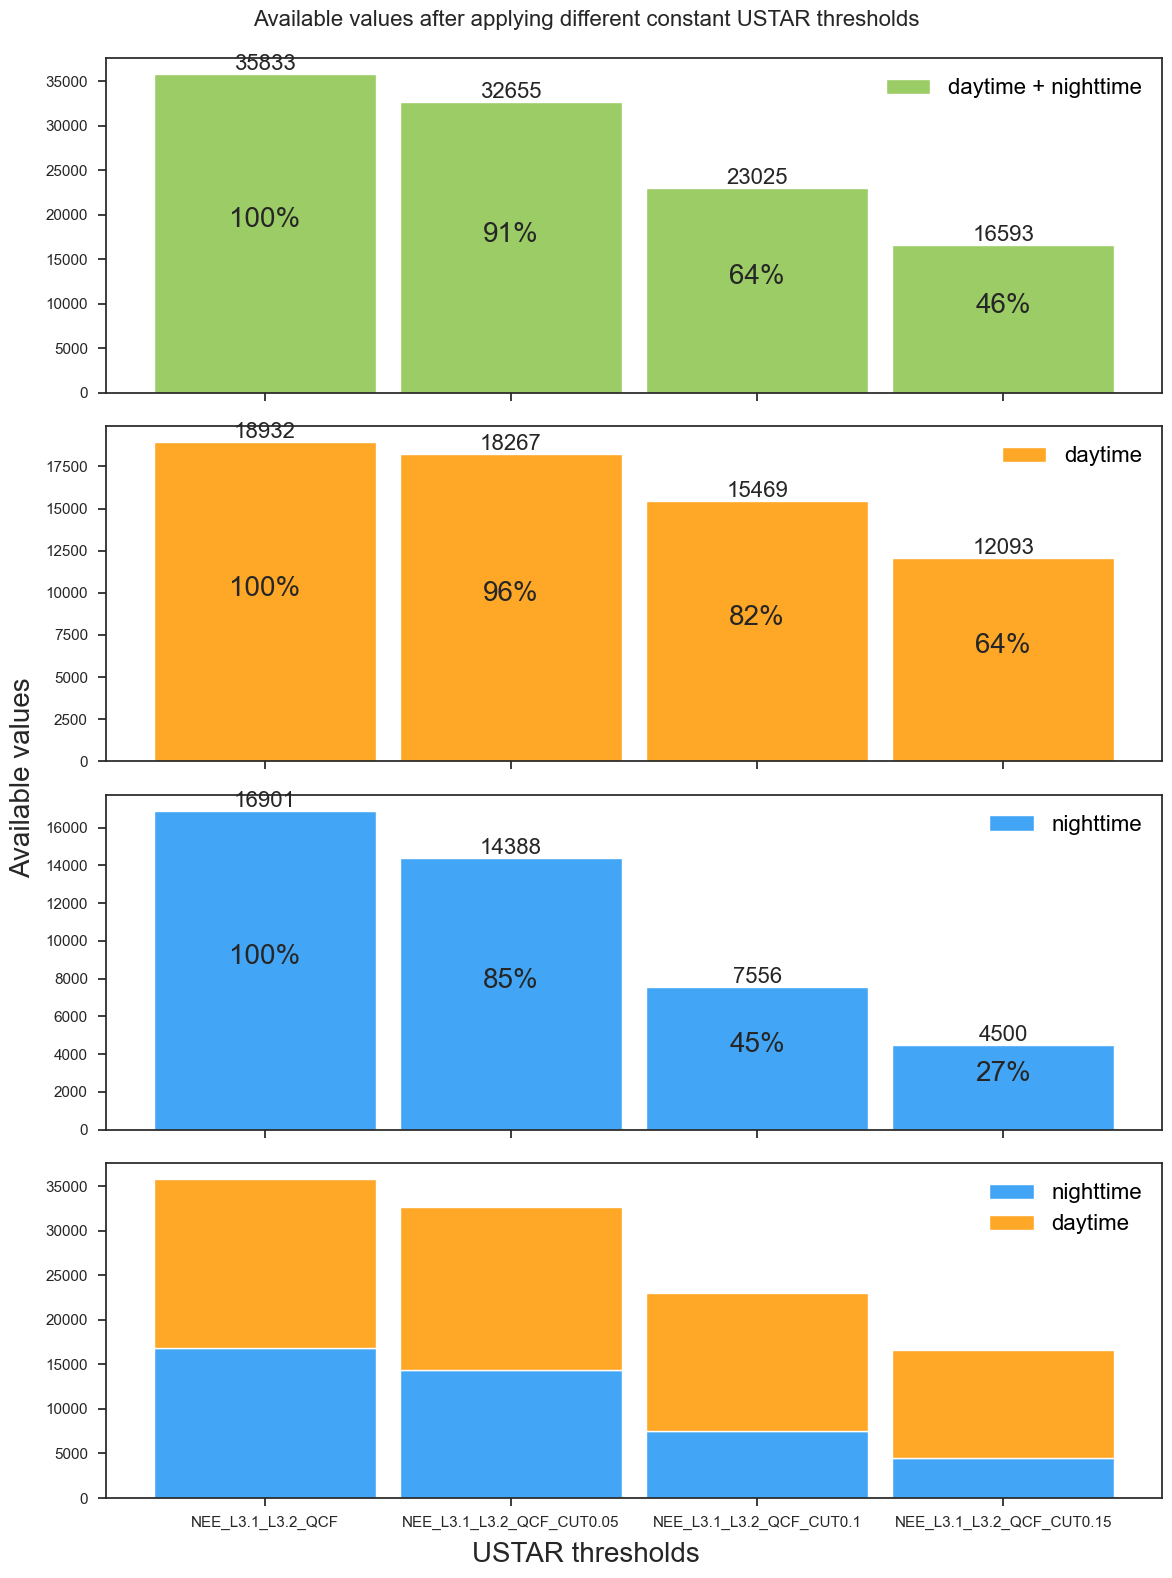

In [92]:
from diive.pkgs.flux.ustarthreshold import UstarThresholdConstantScenarios
ust = UstarThresholdConstantScenarios(series=_maindf[FLUXVAR32QCF],
                                      swinpot=_maindf['SW_IN_POT'],
                                      ustar=maindf['USTAR'])
ust.calc(ustarthresholds=[0.05, 0.1, 0.15], showplot=True, verbose=True)

## *(Preliminary) Apply constant USTAR threshold*
- Use constant USTAR threshold for all data

(TODO)

</br>

# **End of notebook**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [93]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2024-04-21 02:17:58
